In [1]:
# Code to plot Kepler light curve on top of simulatied light curve
# and then try to match both of them
# also ML Prediction on Interpolated Kepler light curve is present

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
import numpy as np
from scipy.interpolate import interp1d


/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model

2023-11-08 14:20:03.687893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 14:20:04.488854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [4]:
kepid_array = np.load("../data/tfr_shallue/npy_shallue/kepid.npy")
print('kepid_load = ',kepid_array[0])

av_training_set_array = np.load("../data/tfr_shallue/npy_shallue/av_training_set.npy")
print('av_training_set_array = ',av_training_set_array[0])

# global_view_array = np.load("../data/tfr_shallue/npy_shallue/global_view.npy")
# print('global_view_array = ',global_view_array[0])

local_view_array = np.load("../data/tfr_shallue/npy_shallue/local_view.npy")
print('local_view_array = ',local_view_array[0])


kepid_load =  11709124.0
av_training_set_array =  b'P'
local_view_array =  [-6.92397356e-02 -2.56392676e-02 -4.75080535e-02 -6.34126291e-02
 -2.86556520e-02 -7.22561181e-02 -7.22561181e-02  1.56303551e-02
  3.60595062e-02  5.99163622e-02  5.51175699e-02 -4.38746847e-02
  6.16987748e-03  4.48344424e-02  2.11146921e-02  1.93322822e-02
  4.11325163e-04 -4.53828759e-02 -5.10728732e-02 -5.02502210e-02
 -3.57852876e-02 -9.18626133e-03  3.29060107e-02  5.47062457e-02
 -7.54096126e-03  1.37108378e-04  2.26228833e-02  2.57763769e-02
  1.12977311e-01  9.85809267e-02  7.41756335e-02  3.29060107e-02
 -7.87687674e-02  2.42681839e-02  1.53561393e-02  8.08939431e-03
 -1.70014389e-02 -8.80235806e-02 -7.41756335e-02 -7.97970816e-02
 -5.81339560e-02 -2.64619179e-02 -3.08493860e-02  2.33084261e-02
 -3.53739634e-02 -3.53739634e-02  1.37108390e-03  1.09686712e-02
 -1.68643314e-02  1.72756556e-02  1.87838487e-02  1.87838487e-02
  2.60505918e-03  6.95139542e-02 -4.53828759e-02 -6.64975643e-02
  6.71831099e-0

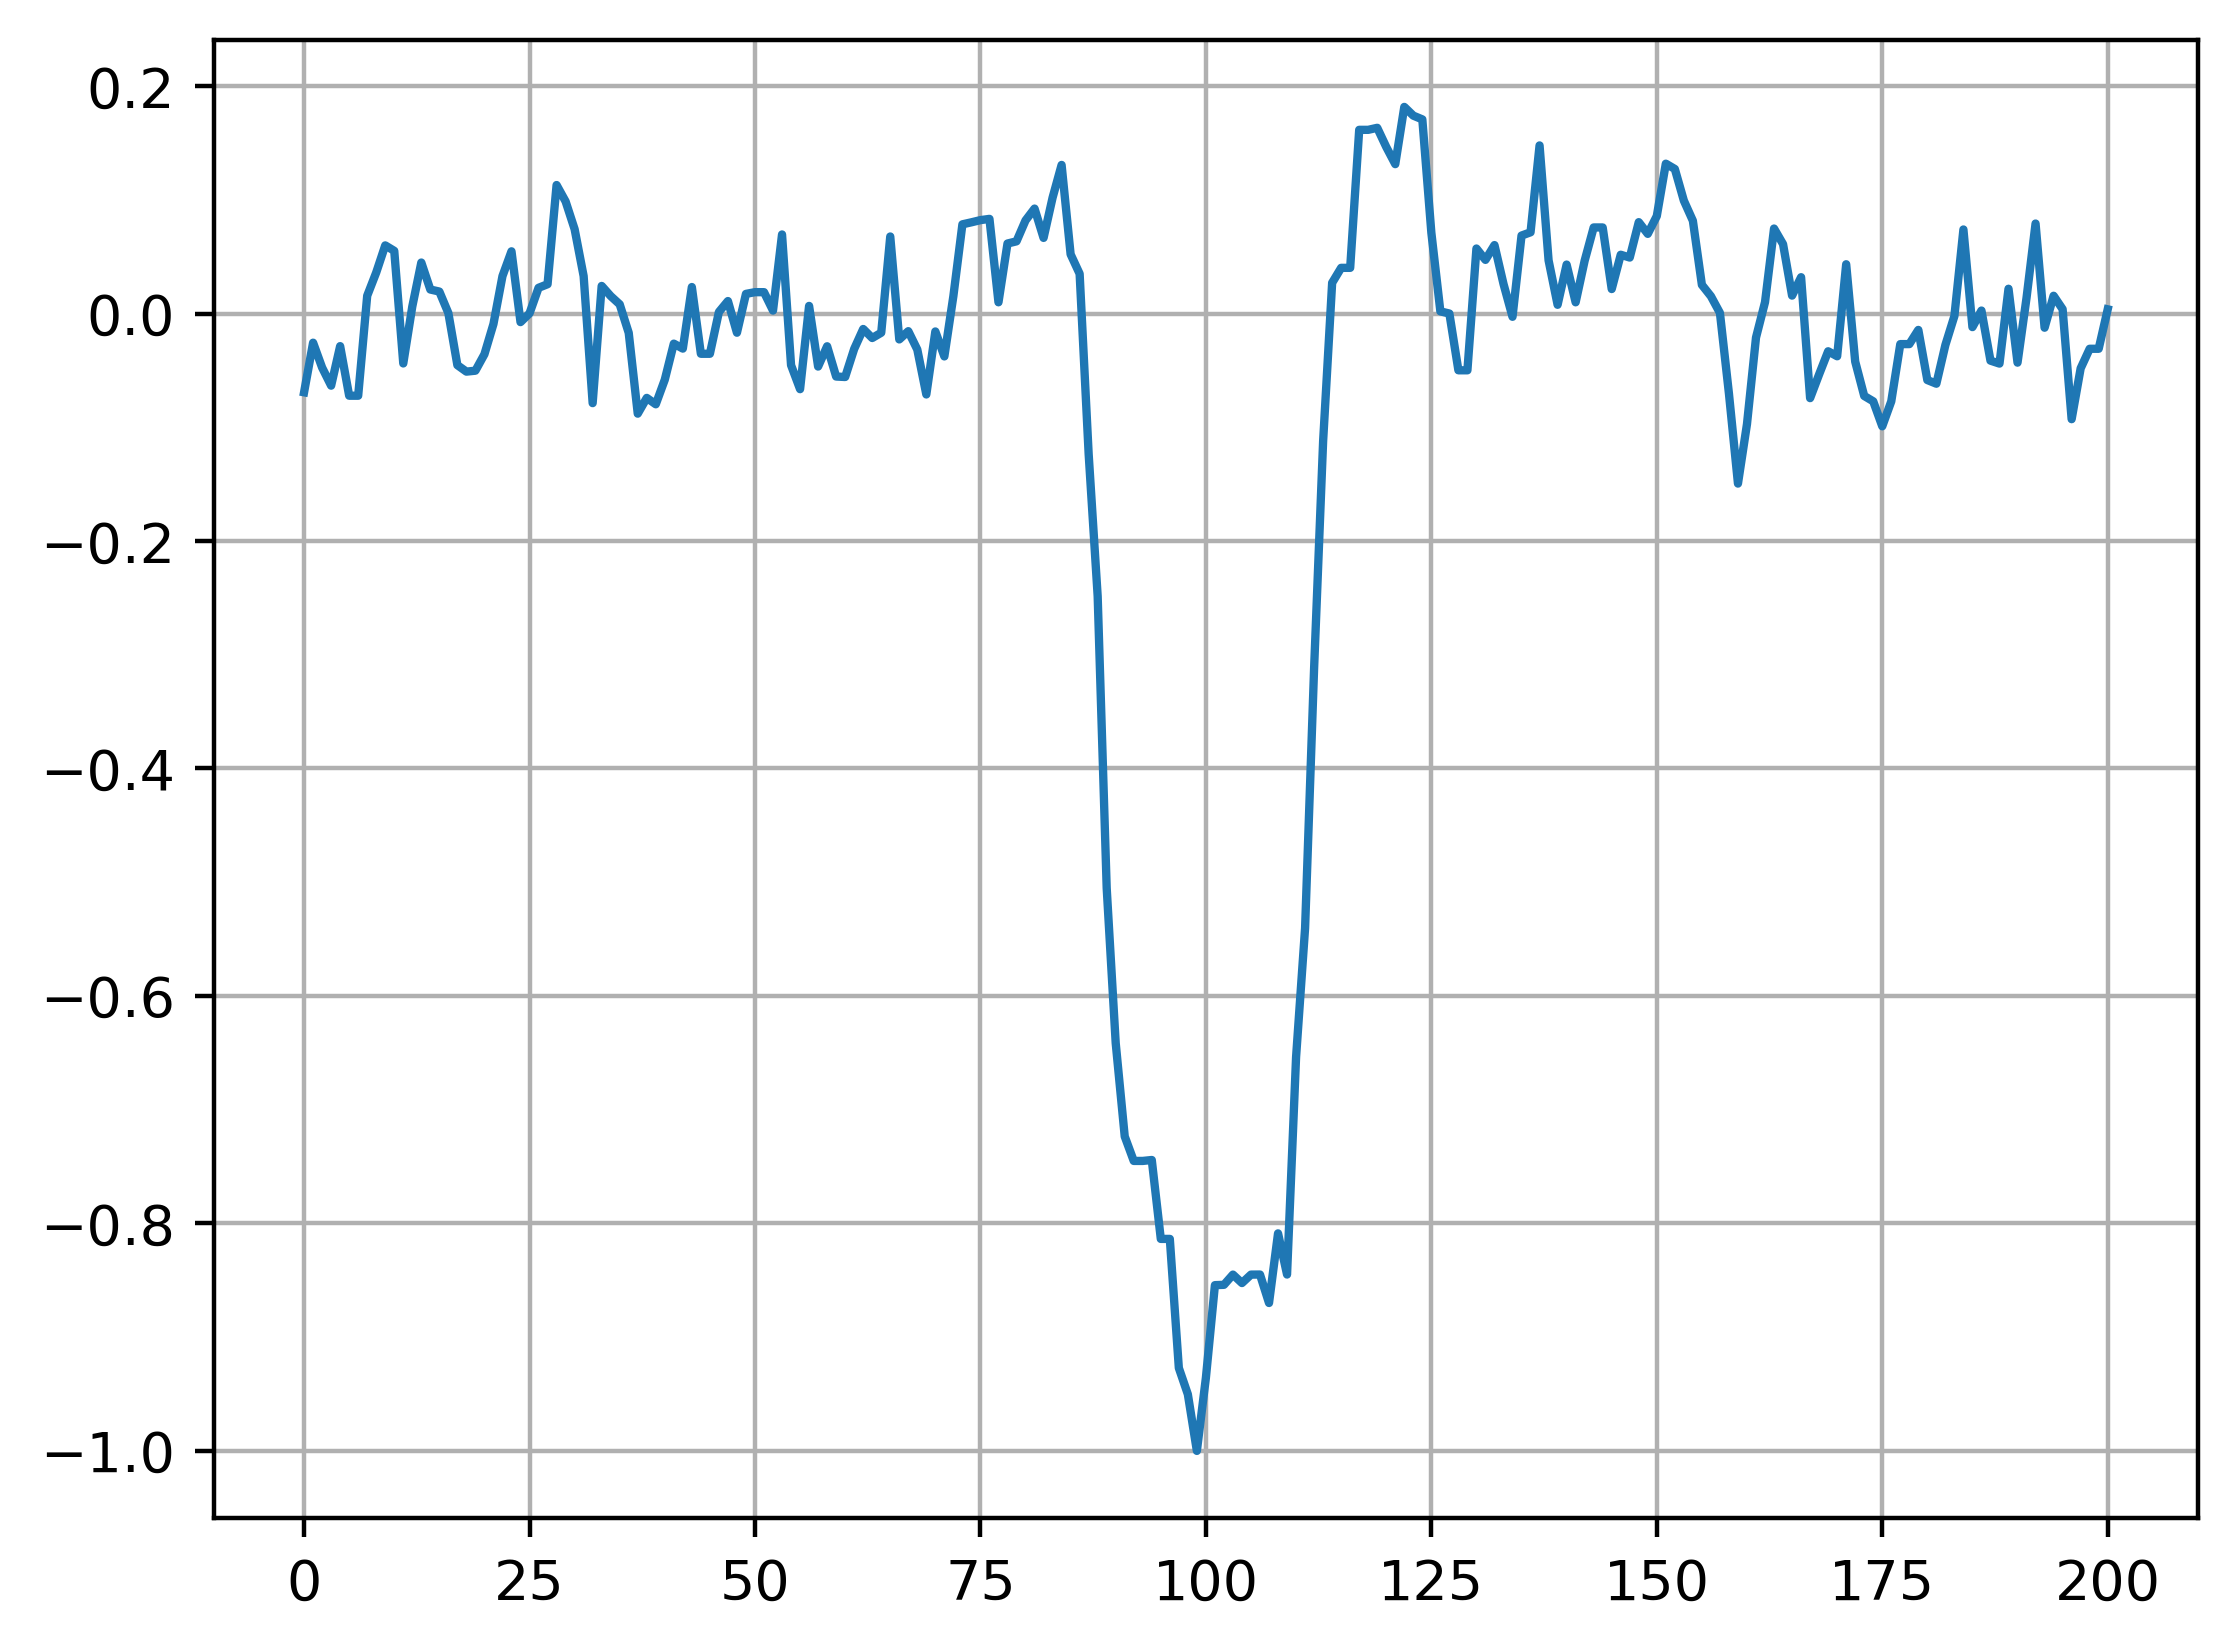

In [5]:
# Plot one light curve (local)
plt.grid('on')
plt.plot(np.arange(len(local_view_array[0])),local_view_array[0])
plt.show()

In [6]:
# Calculate SNR for each Local view lc and save them in an array
local_view_array = local_view_array + 1
noise_array = np.zeros((len(local_view_array),120))
for i in np.arange(len(local_view_array)):
    noise_array[i][0:60] = local_view_array[i,0:60]
    noise_array[i][60:120] = local_view_array[i,141:202]
std_devs_Kepler = np.array([np.std(arr) for arr in noise_array])
SNR_Kepler = 1/std_devs_Kepler

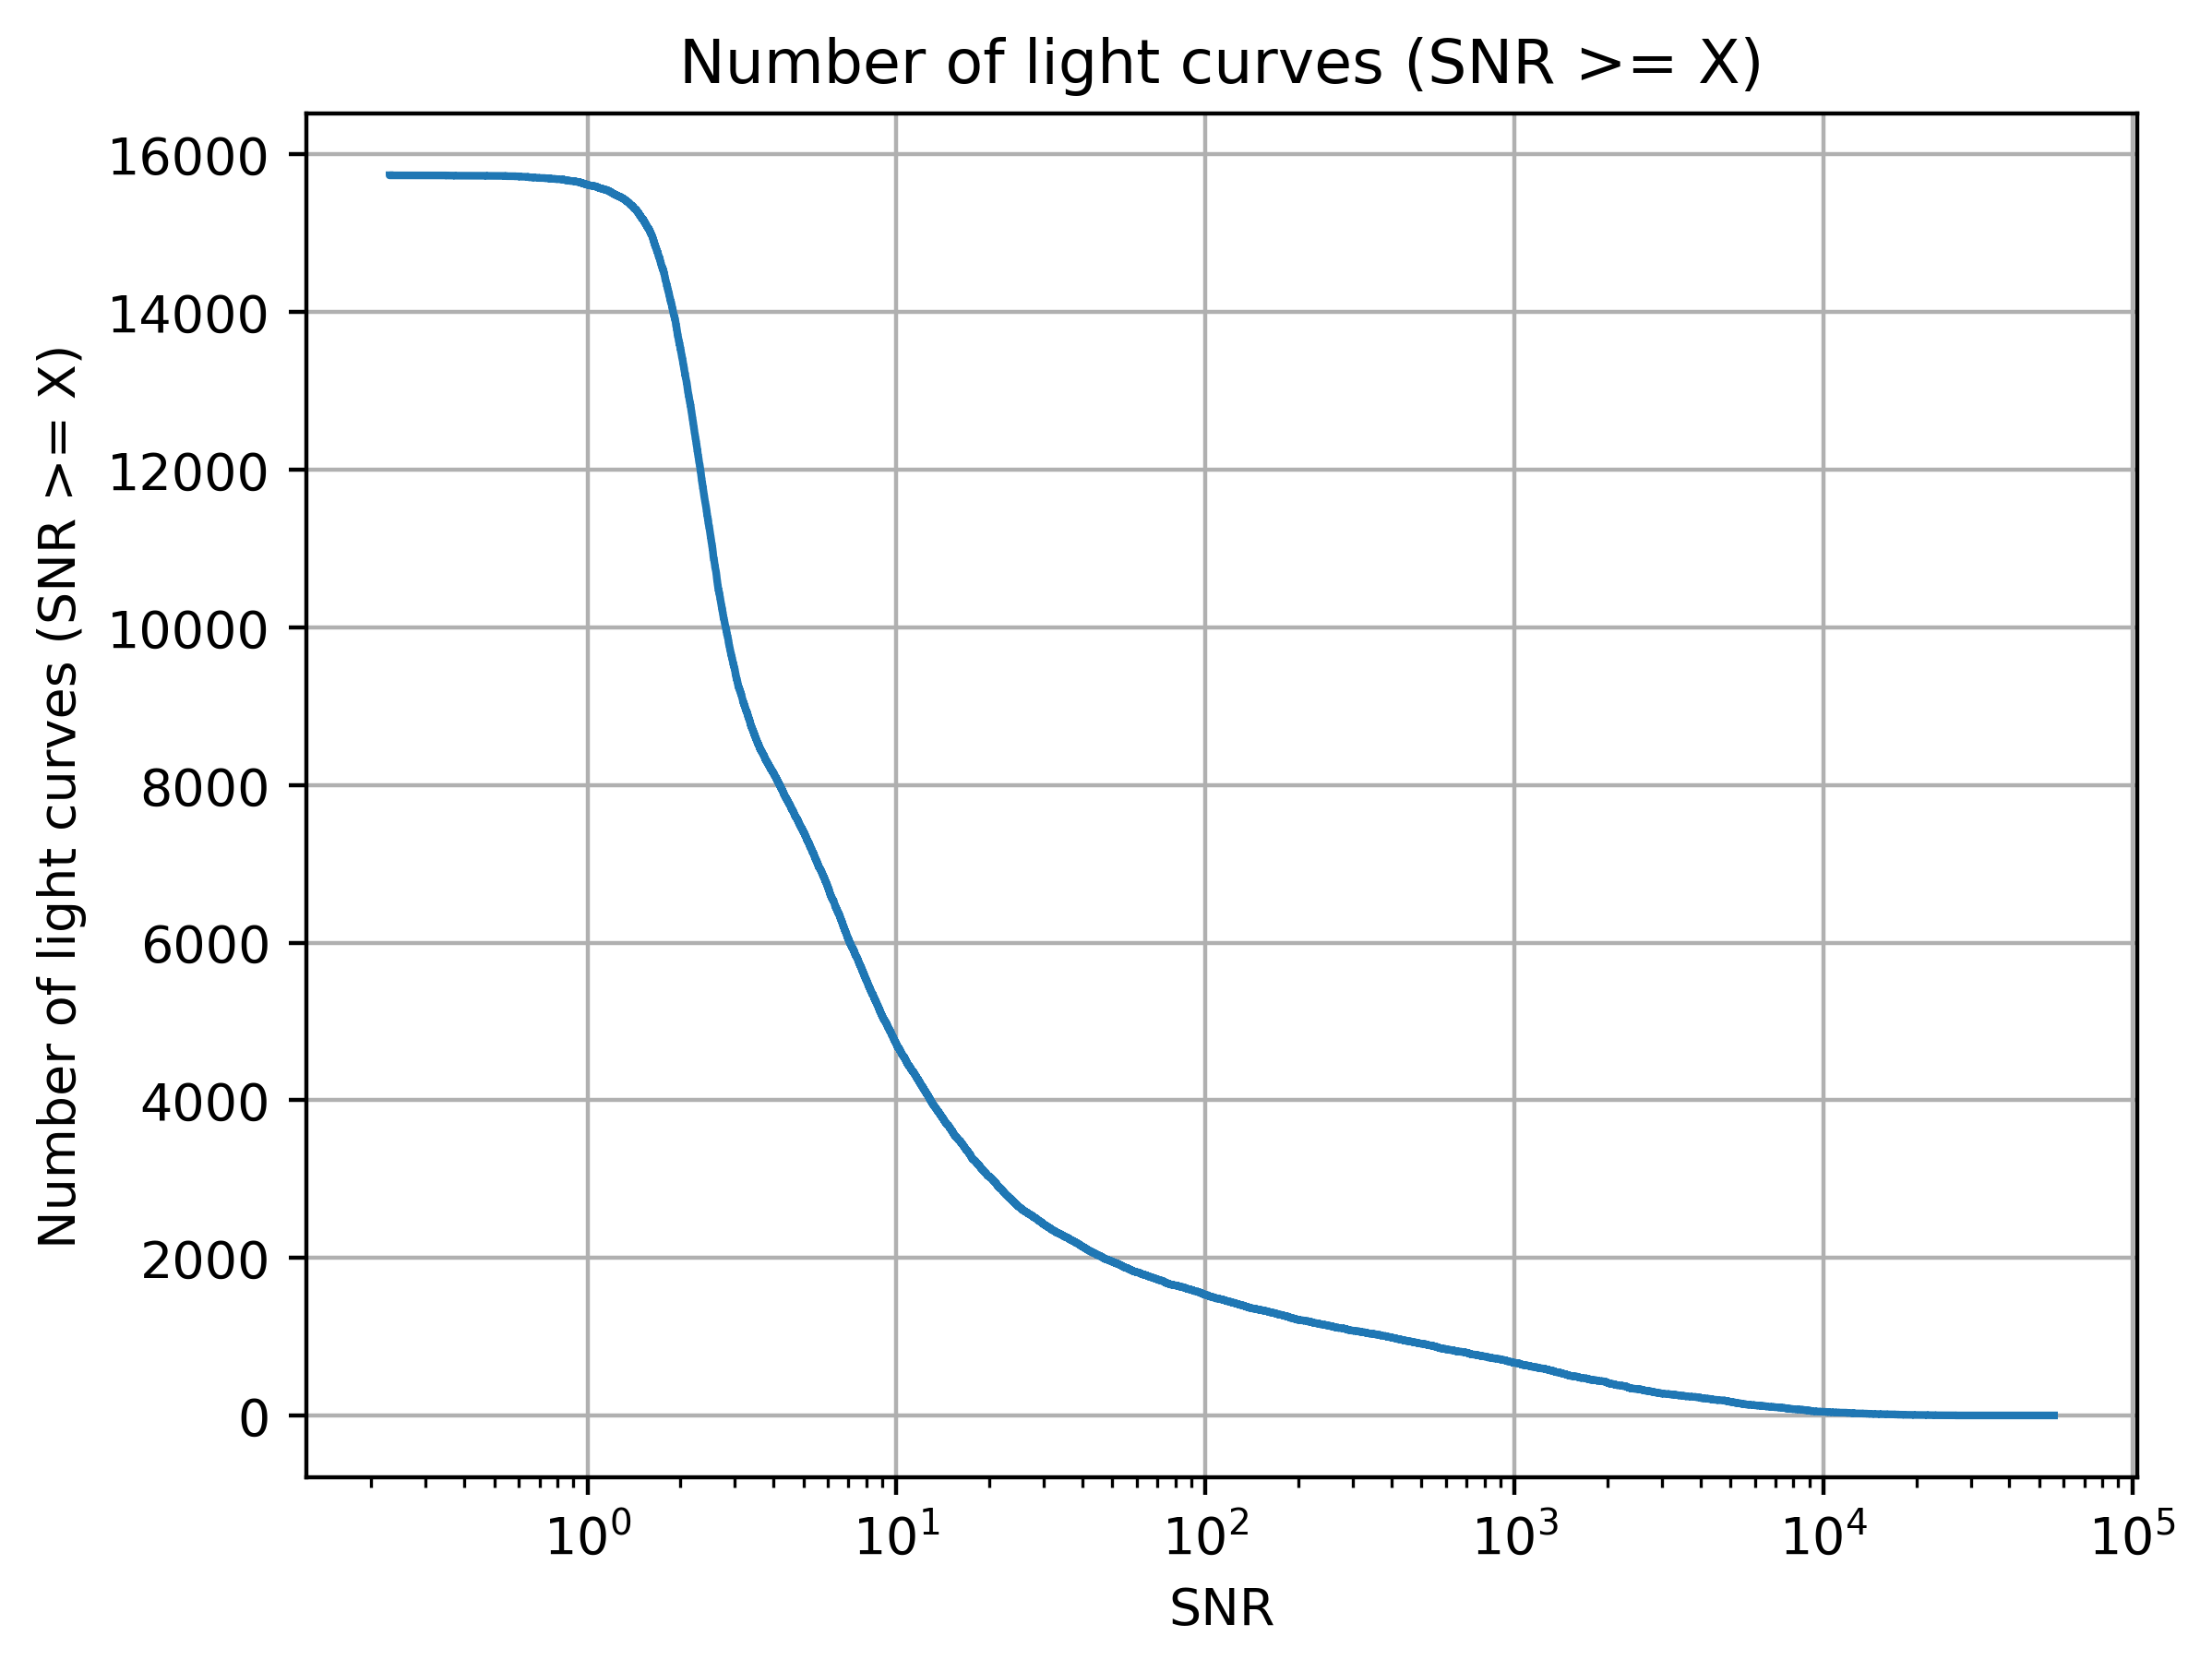

In [7]:
# Code to plot the cumulative number of SNR>X
# Calculate the inverse cumulative distribution

# Sort the data in ascending order
SNR_Kepler_sorted = np.sort(SNR_Kepler)
inverse_cumulative = np.arange(len(SNR_Kepler_sorted), 0, -1)

# Create the inverse cumulative distribution plot
plt.step(SNR_Kepler_sorted, inverse_cumulative)
plt.xlabel('SNR')
plt.ylabel('Number of light curves (SNR >= X)')
plt.title('Number of light curves (SNR >= X)')
plt.grid(True)
plt.xscale('log')

# Show the plot
plt.show()

In [8]:
# Code to show the properties of the light curves in Kepler Dataset
print(f"Total no. of light curves in Kepler Dataset = ",len(SNR_Kepler))
print("\tTotal No. of planets = ",len(np.where(av_training_set_array==b'P')[0]))
print("\tTotal no. of non-transiting phenomenon = ",len(np.where(av_training_set_array==b'N')[0]))
print("\tTotal no. of astrophysical false positive = ",len(np.where(av_training_set_array==b'A')[0]))
print("\n---\n")
SNR_Threshold_array = [50,75,100,500]
for SNR_Threshold in SNR_Threshold_array:
    selected_kepler_index_mask = SNR_Kepler > SNR_Threshold
    selected_kepler_index = np.where(selected_kepler_index_mask)[0]
    print(f"For SNR >  {SNR_Threshold}")
    print(f"\tNo. of light curves = ",len(selected_kepler_index))
    # print("Index where label = Planet: ",np.where(lc_label_array[selected_kepler_index]==b'P')[0])
    print("\tNo. of planets = ",len(np.where(av_training_set_array[selected_kepler_index]==b'P')[0]))
    print("\tNo. of non-transiting phenomenon = ",len(np.where(av_training_set_array[selected_kepler_index]==b'N')[0]))
    print("\tNo. of astrophysical false positive = ",len(np.where(av_training_set_array[selected_kepler_index]==b'A')[0]))

    # print('selected_kepler_index_mask = ',selected_kepler_index_mask)
    # print('selected_kepler_index = ',selected_kepler_index)
    

Total no. of light curves in Kepler Dataset =  15737
	Total No. of planets =  3600
	Total no. of non-transiting phenomenon =  2541
	Total no. of astrophysical false positive =  9596

---

For SNR >  50
	No. of light curves =  1952
	No. of planets =  364
	No. of non-transiting phenomenon =  21
	No. of astrophysical false positive =  1567
For SNR >  75
	No. of light curves =  1681
	No. of planets =  256
	No. of non-transiting phenomenon =  17
	No. of astrophysical false positive =  1408
For SNR >  100
	No. of light curves =  1530
	No. of planets =  206
	No. of non-transiting phenomenon =  16
	No. of astrophysical false positive =  1308
For SNR >  500
	No. of light curves =  912
	No. of planets =  41
	No. of non-transiting phenomenon =  14
	No. of astrophysical false positive =  857


No. of light curves with SNR > 100 =  1530
Total no. of light curves =  15737


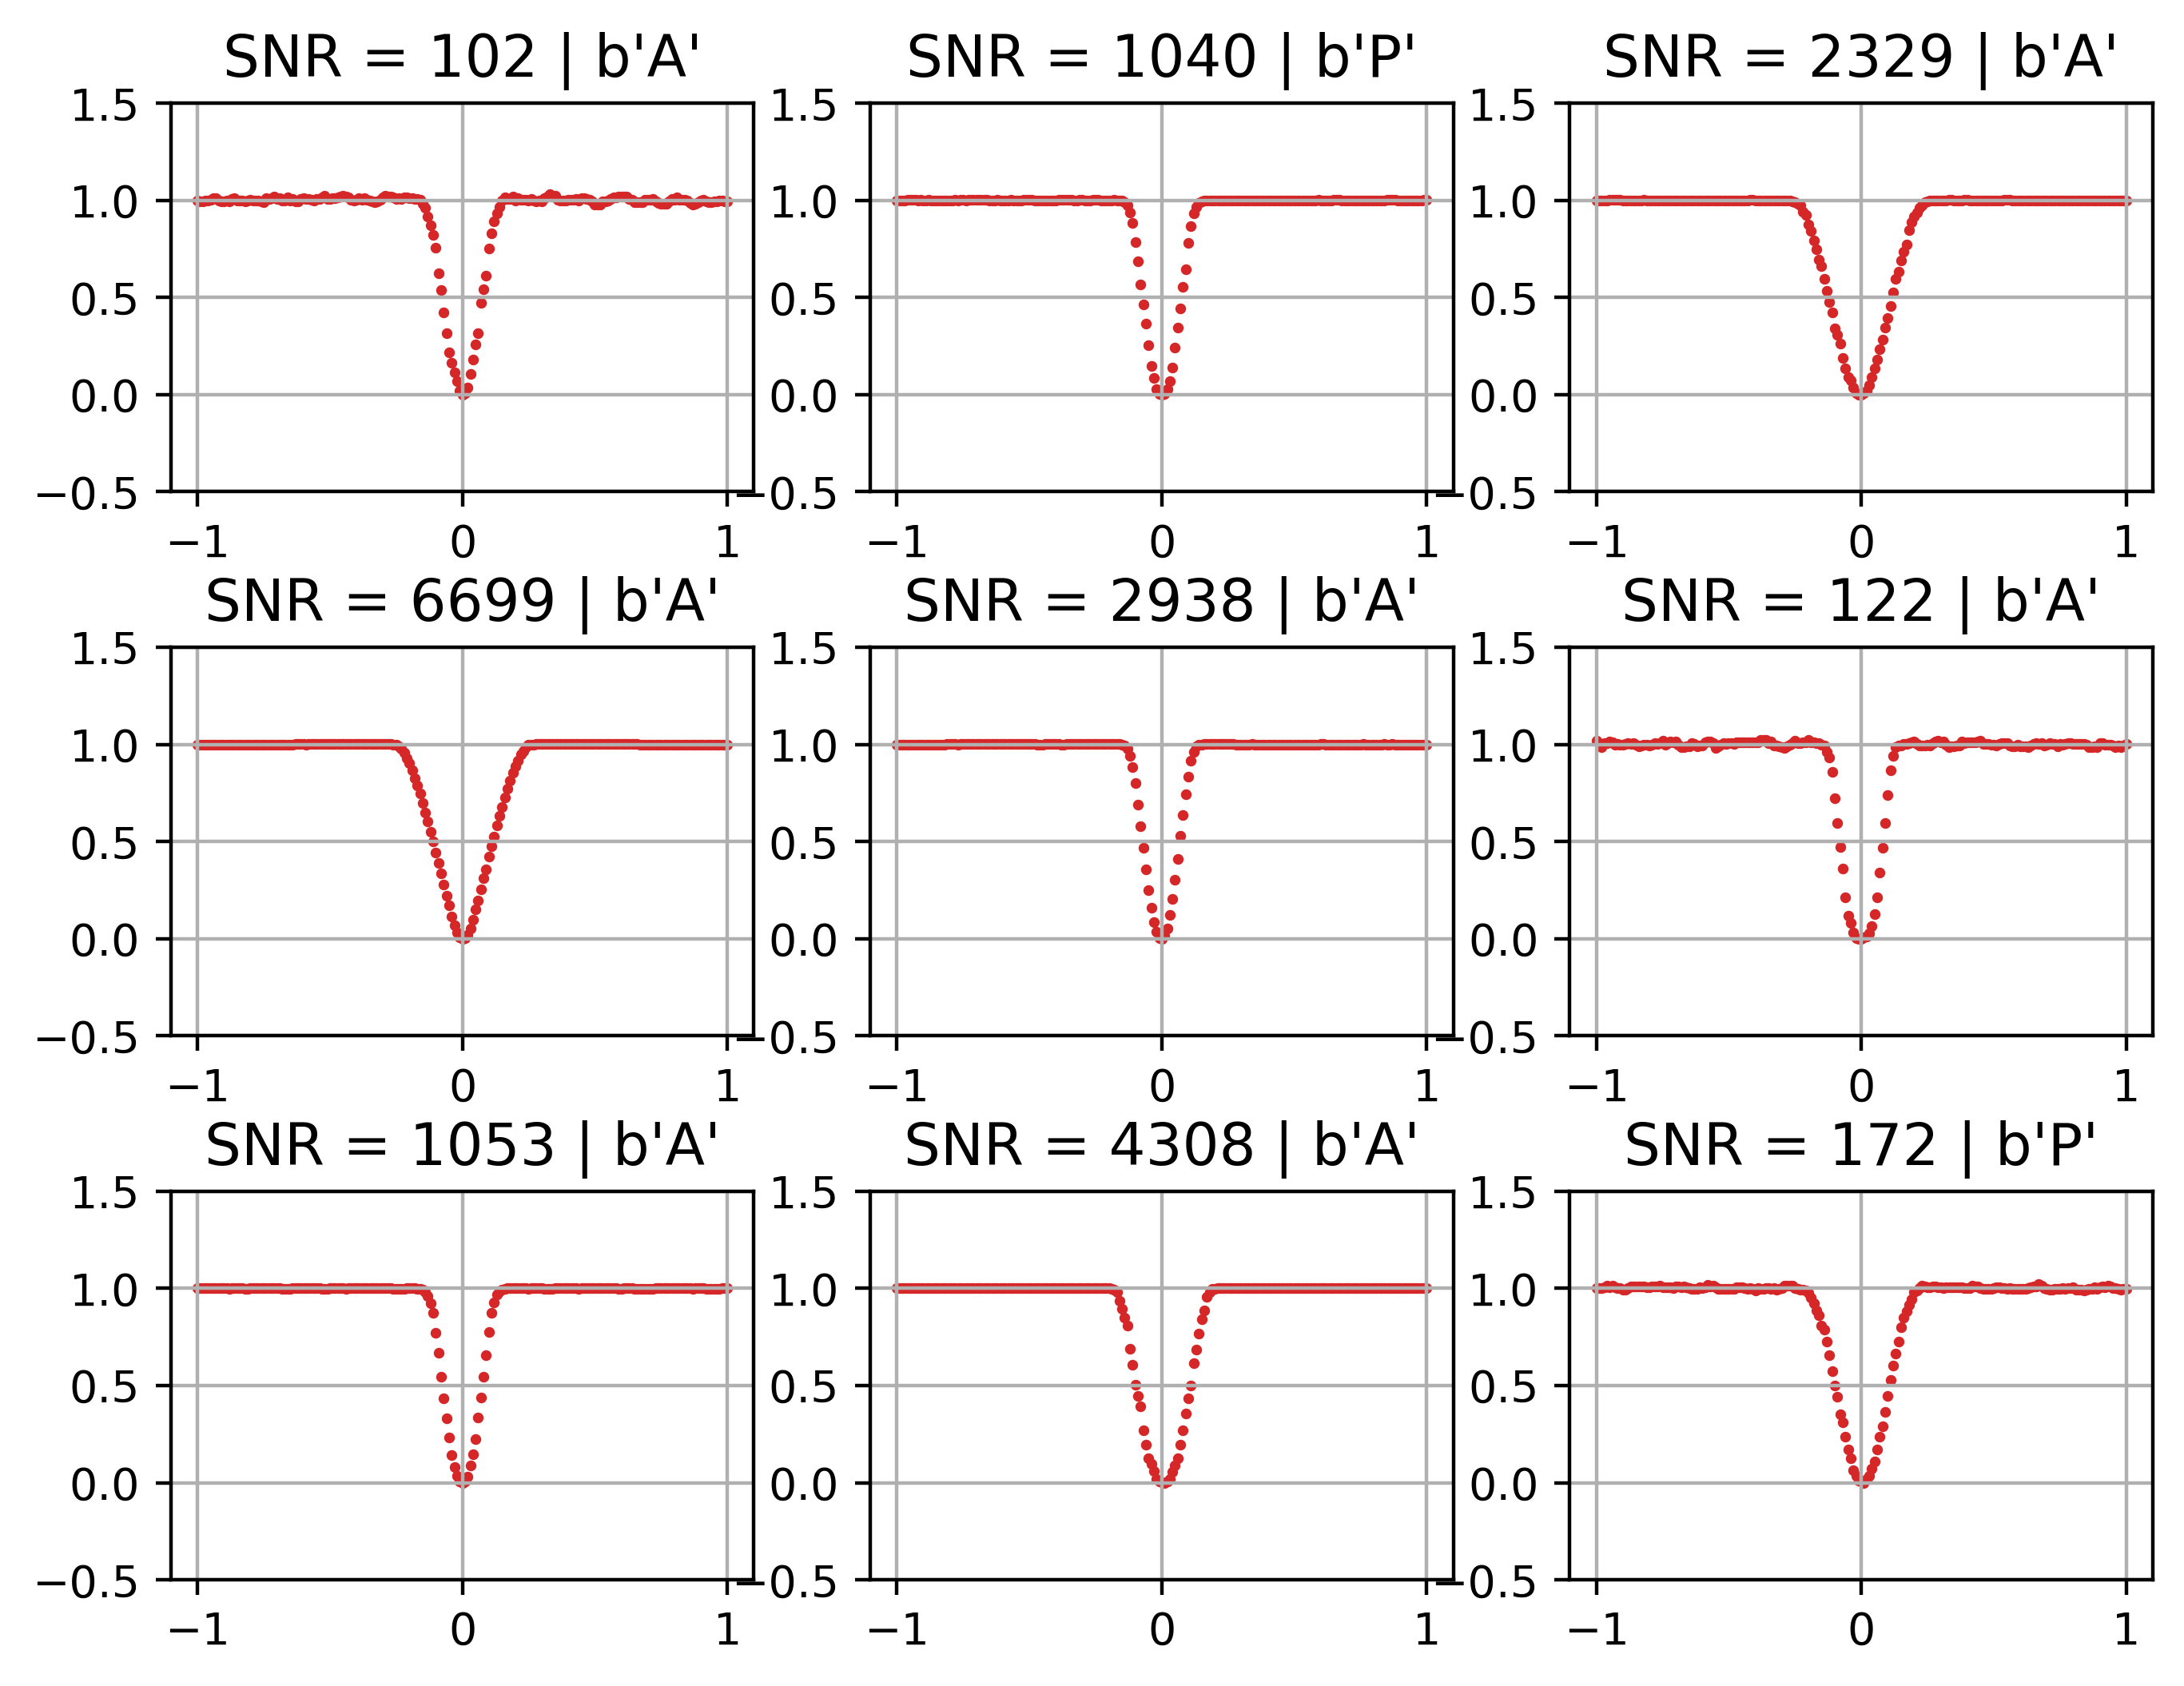

In [100]:
# Save the index of the light curve with SNR > 500
# and plot them
# select_kepler_lc = lc_np_array[SNR_Kepler>75]
# select_kepler_lc = select_kepler_lc + 1

SNR_Threshold = 100
selected_kepler_index_mask = ((SNR_Kepler > SNR_Threshold)) # & (av_training_set_array==b'P')) 
selected_kepler_index = np.where(selected_kepler_index_mask)[0]
print(f"No. of light curves with SNR > {SNR_Threshold} = ",len(selected_kepler_index))
print(f"Total no. of light curves = ",len(SNR_Kepler))
# Plot the selected light curves 3 x 3
num = 3
fig,ax=plt.subplots(num,3, figsize=(8,6), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})

# ax[0][1].set_title('Shape',size=15)
# ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
# ax[num-1][0].set_xlabel('Phase',size=13)
ph_kepler = np.linspace(-1,1,len(local_view_array[0]))


i = 0
for i in np.arange(0,num):
    # k = np.random.randint(0, len(select_kepler_lc)-50)
    k = int(np.random.choice(selected_kepler_index))
    ax[i][0].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {av_training_set_array[k]}',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph_kepler, local_view_array[k],color = 'tab:red',s=2)
    ax[i][0].grid('on')

    k = int(np.random.choice(selected_kepler_index))
    ax[i][1].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {av_training_set_array[k]}',size=13)
    ax[i][1].set_ylim(-0.5,1.5)
    ax[i][1].scatter(ph_kepler, local_view_array[k],color = 'tab:red',s=2)
    ax[i][1].grid('on')

    k = int(np.random.choice(selected_kepler_index))
    ax[i][2].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {av_training_set_array[k]}',size=13)
    ax[i][2].set_ylim(-0.5,1.5)
    ax[i][2].scatter(ph_kepler, local_view_array[k],color = 'tab:red',s=2)
    ax[i][2].grid('on')
    i = i + 1

In [101]:
# ## Code to shift the light curve to the centre

# # Check whether any index for phase axis phase is 0
# print('np.where(ph_kepler == 0)[0] = ', np.where(ph_kepler == 0)[0]) # OP: np.where(ph == 0)[0] =  [100]
# print('len(ph_kepler) = ',len(ph_kepler)) # OP: len(ph) =  201

# # Calculate the index where light curve is at minimum and shift it
# min_index = np.zeros(len(local_view_array))
# for iter in np.arange(len(local_view_array)):
#     min_index[iter] = np.argmin(local_view_array[iter])
#     # Calculate the number of positions to shift the array
#     shift_amount = len(local_view_array[iter]) // 2 - min_index[iter]

#     # Shift the array to bring the minimum value to the central index
#     local_view_array[iter] = np.roll(local_view_array[iter], int(shift_amount))
#     min_index[iter] = np.argmin(local_view_array[iter])

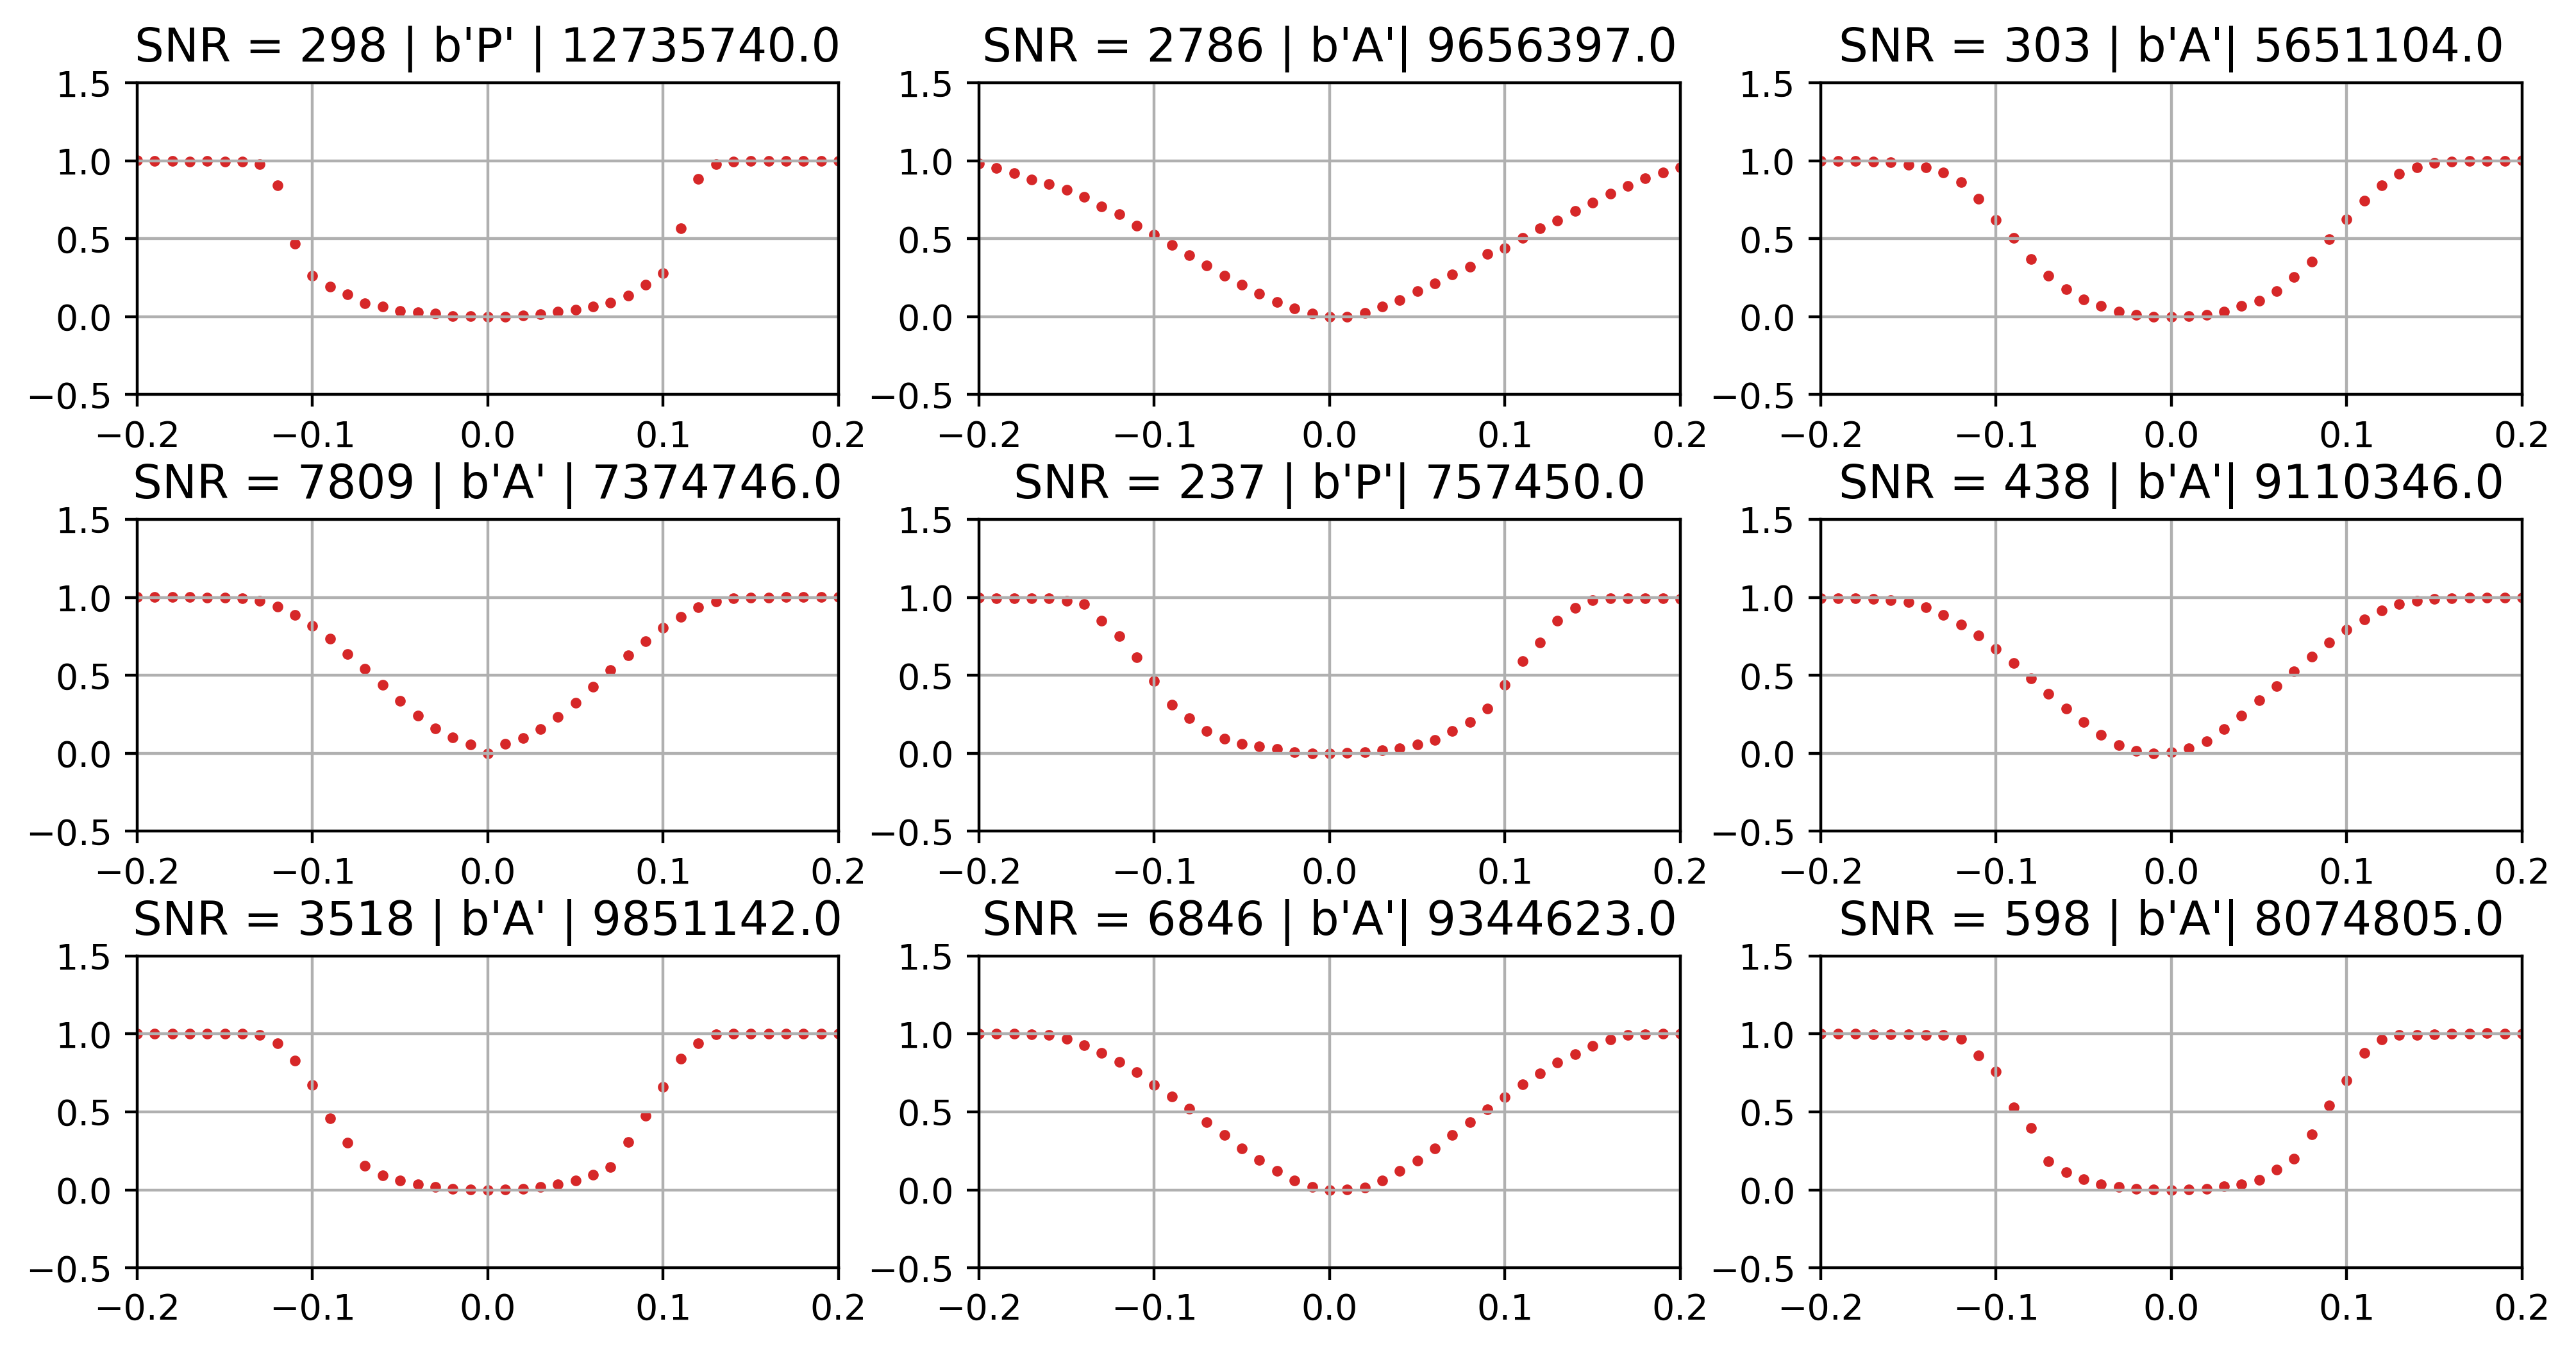

In [102]:
# Plot the selected light curves 3 x 3
num = 3
fig,ax=plt.subplots(num,3, figsize=(12,6), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})

# ax[0][1].set_title('Shape',size=15)
# ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
# ax[num-1][0].set_xlabel('Phase',size=13)
ph_kepler = np.linspace(-1,1,len(local_view_array[0]))


i = 0
for i in np.arange(0,num):
    # k = np.random.randint(0, len(select_kepler_lc)-50)
    k = int(np.random.choice(selected_kepler_index))
    ax[i][0].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {av_training_set_array[k]} | {kepid_array[k]}',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].set_xlim(-0.2,+0.2)
    ax[i][0].scatter(ph_kepler, local_view_array[k],color = 'tab:red',s=4)
    ax[i][0].grid('on')

    k = int(np.random.choice(selected_kepler_index))
    ax[i][1].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {av_training_set_array[k] }| {kepid_array[k]}',size=13)
    ax[i][1].set_ylim(-0.5,1.5)
    ax[i][1].set_xlim(-0.2,+0.2)
    ax[i][1].scatter(ph_kepler, local_view_array[k],color = 'tab:red',s=4)
    ax[i][1].grid('on')

    k = int(np.random.choice(selected_kepler_index))
    ax[i][2].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {av_training_set_array[k]}| {kepid_array[k]}',size=13)
    ax[i][2].set_ylim(-0.5,1.5)
    ax[i][2].set_xlim(-0.2,+0.2)
    ax[i][2].scatter(ph_kepler, local_view_array[k],color = 'tab:red',s=4)
    ax[i][2].grid('on')
    i = i + 1

In [103]:
# 1. Load Dataset
## Load Train Set
# train_shape_dir = '../data/data_npy/shape_npy/shape_filled5.npy'
# train_lc_dir = '../data/data_npy/lc_npy/lc_dict_5.npy'

train_shape_dir = '../data/train/npy/shape/shape_5.npy'
train_lc_dir =  '../data/train/npy/lc/lc_1_shape_5.npy'
# train_lc_dir =  '../data/train/npy/lc/lc_2_shape_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
# vald_shape_dir = '../data/data_npy/shape_npy/shape_filled4.npy'
# vald_lc_dir = '../data/data_npy/lc_npy/lc_dict_4.npy'

vald_shape_dir = '../data/vald/npy/shape/shape_1.npy'
vald_lc_dir = '../data/vald/npy/lc/lc_1_shape_1.npy'

vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of nuftmber of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")



Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes


In [104]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [105]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [106]:
# Add flat line towards left and right of dip
# 10 data points on each side
# 3. Extend the lightcurves
## Working vvvv
# train_lc_scaled_append = np.ones((train_lc.shape[0],120))
# print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
# print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

# for i in np.arange(len(train_lc_scaled)):
#     train_lc_scaled_append[i,10:110] = train_lc_scaled[i]
## Working ^^^^

## - Train Set 
new_length_for_lc = 120
start_index = int((new_length_for_lc - 100)/2)
stop_index = start_index + 100
train_lc_scaled_append = np.ones((train_lc.shape[0],new_length_for_lc))
print('start_index = ',start_index)
print('stop_index = ',stop_index)
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print(f"len(train_lc_scaled_append[0,{start_index}:{stop_index}]) = ",len(train_lc_scaled_append[0,start_index:stop_index]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,start_index:stop_index] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],new_length_for_lc))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,start_index:stop_index] = vald_lc_scaled[i]
print("Extended the light curves")

start_index =  10
stop_index =  110
train_lc_scaled_append.shape =  (132136, 120)
len(train_lc_scaled_append[0,10:110]) =  100
Extended the light curves


In [107]:
# del train_lc_scaled_append
# del vald_lc_scaled_append

# train_lc_scaled_append = train_lc_scaled
# vald_lc_scaled_append = vald_lc_scaled

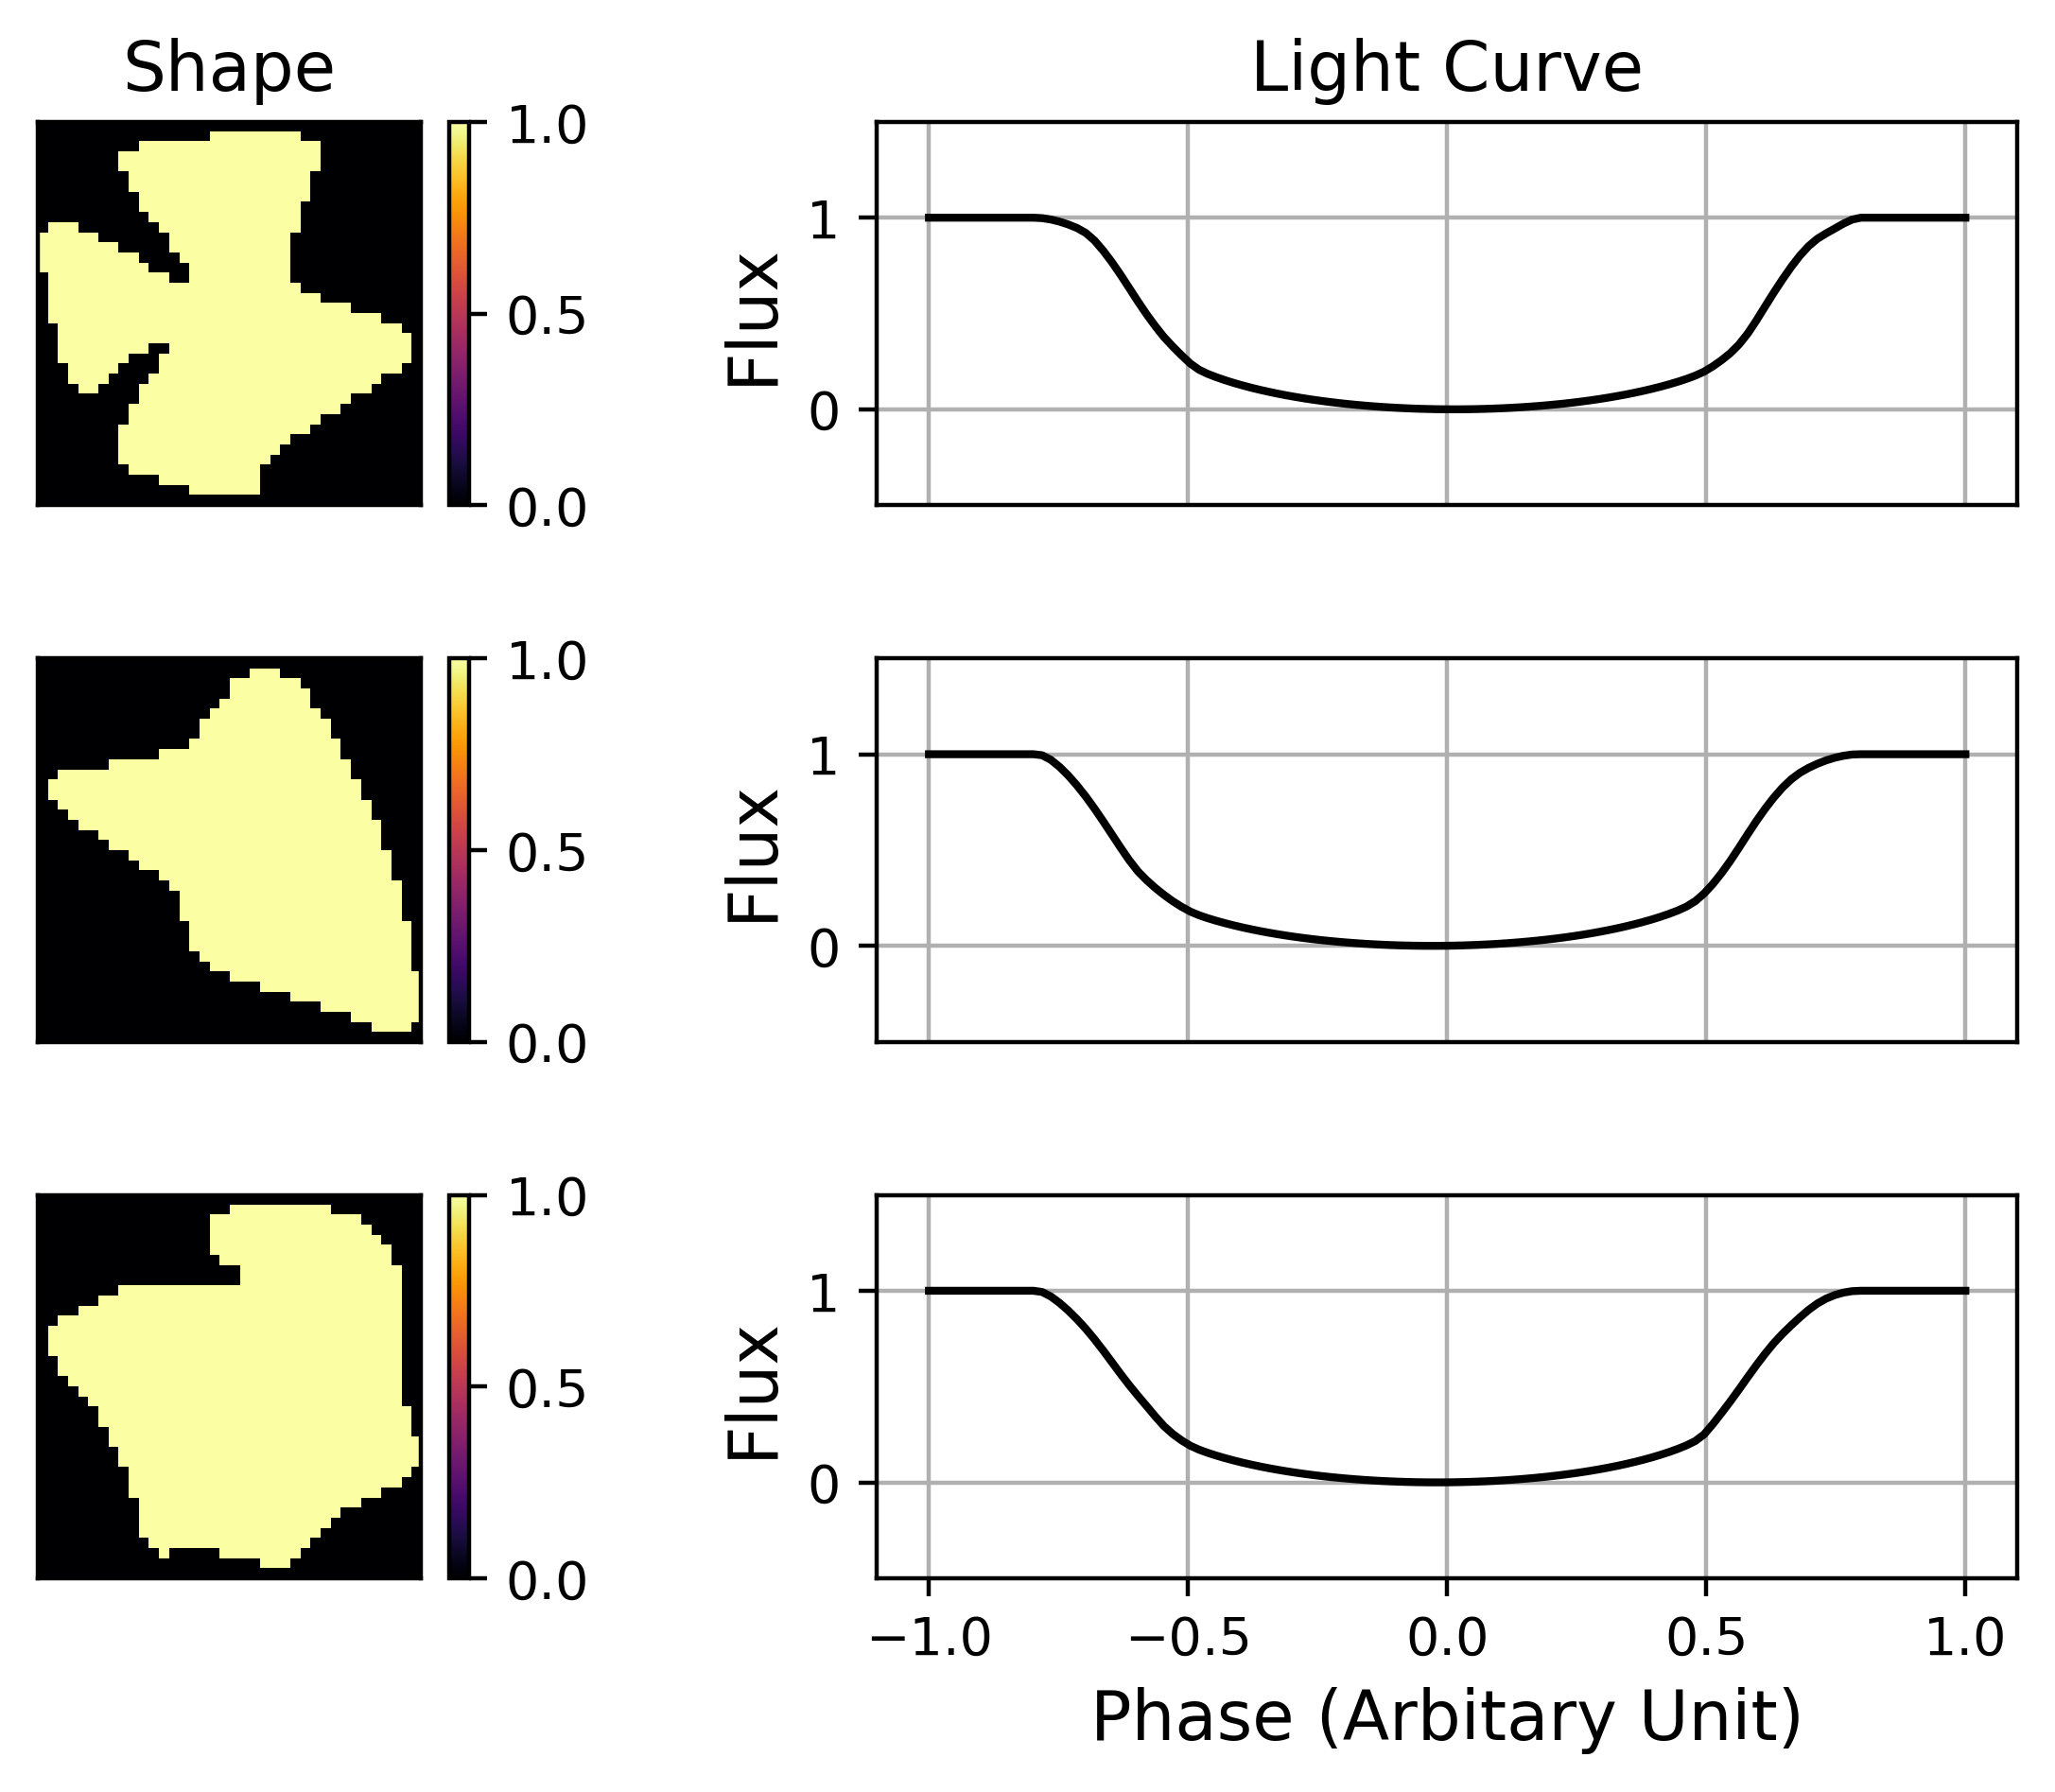

In [108]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(7,5), gridspec_kw={ 'width_ratios': [1,2],
        'wspace': 0.4,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][0].set_title('Shape',size=13)
ax[0][1].set_title('Light Curve',size=13)
ax[num-1][1].set_xlabel('Phase (Arbitary Unit)',size=13)
ph_simul = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][1].tick_params(labelbottom = False, bottom = False)
    img = ax[i][0].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][1].set_ylabel('Flux',size=13)
    ax[i][1].set_ylim(-0.5,1.5)
    # ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][1].plot(ph_simul, train_lc_scaled_append[k],color = 'black',linewidth='1.5')
    ax[i][1].grid('on')
    i = i + 1

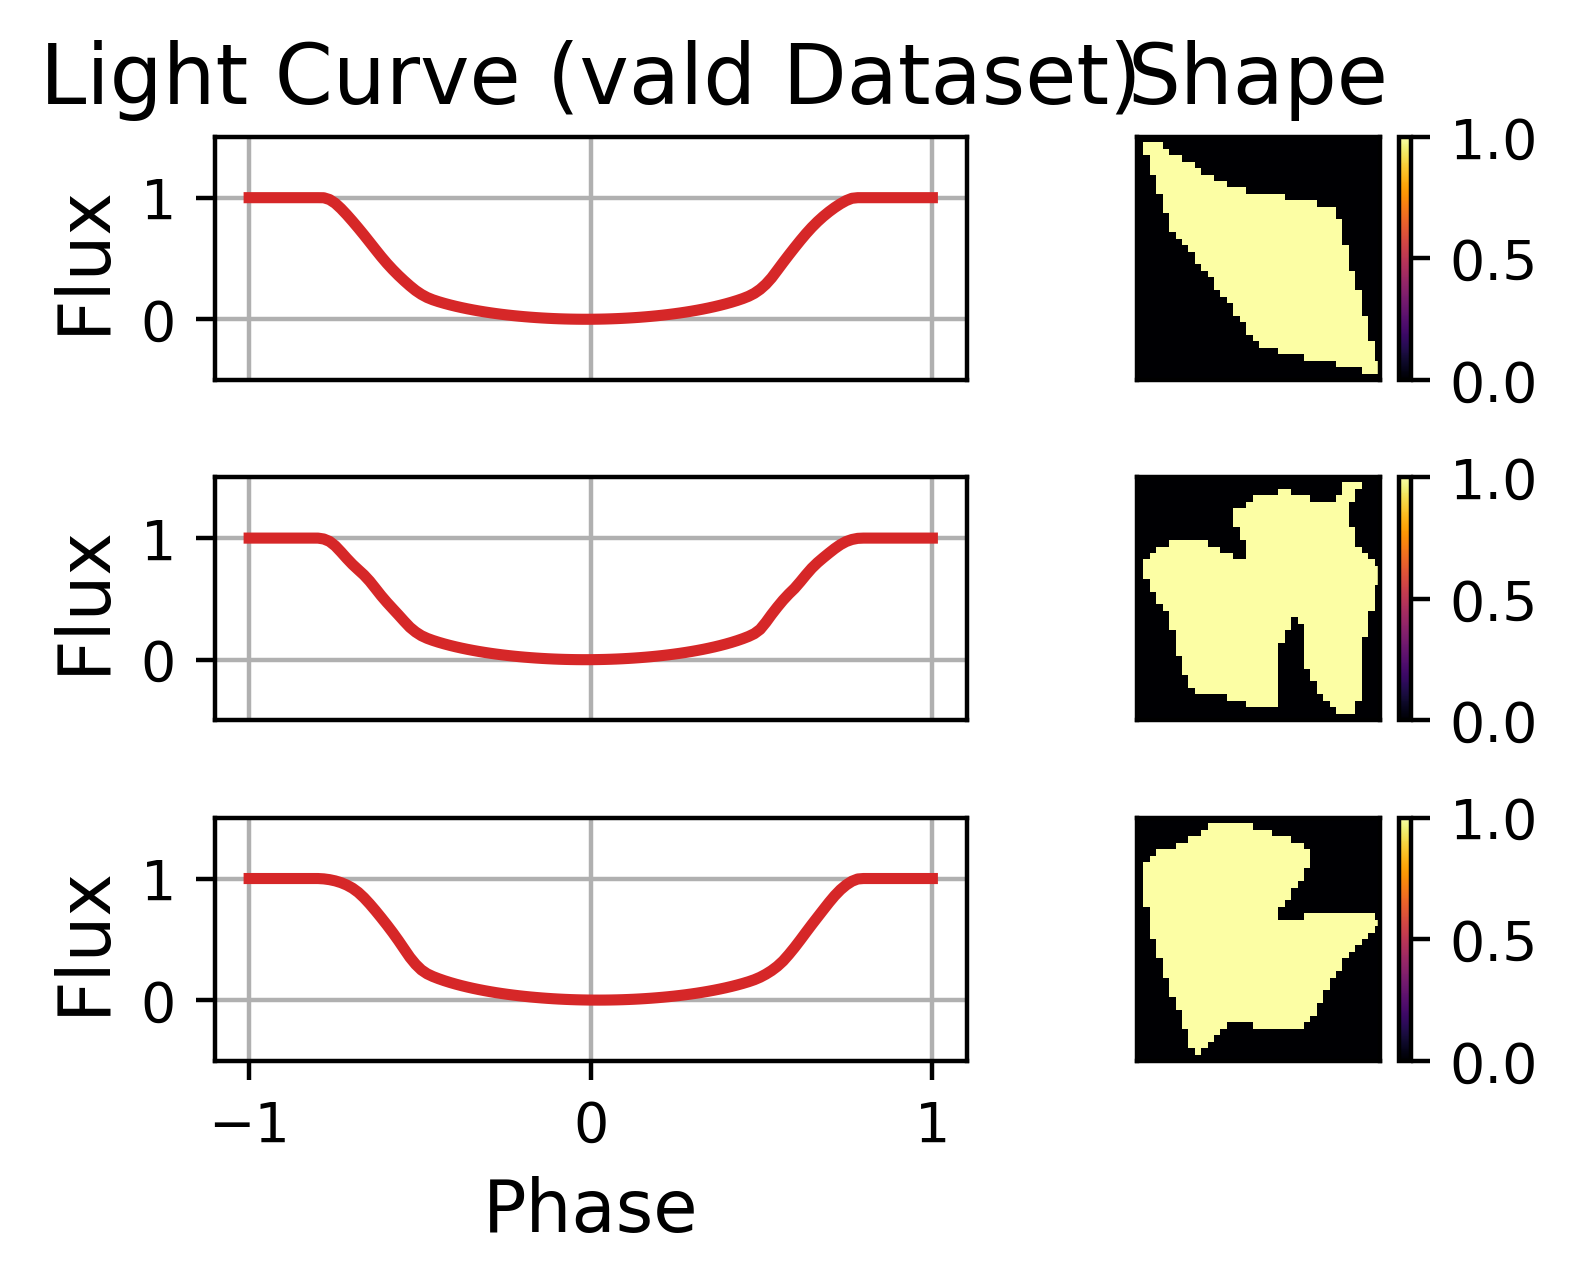

In [109]:
# Verification
# Plot - vald LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (vald Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph_simul, vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

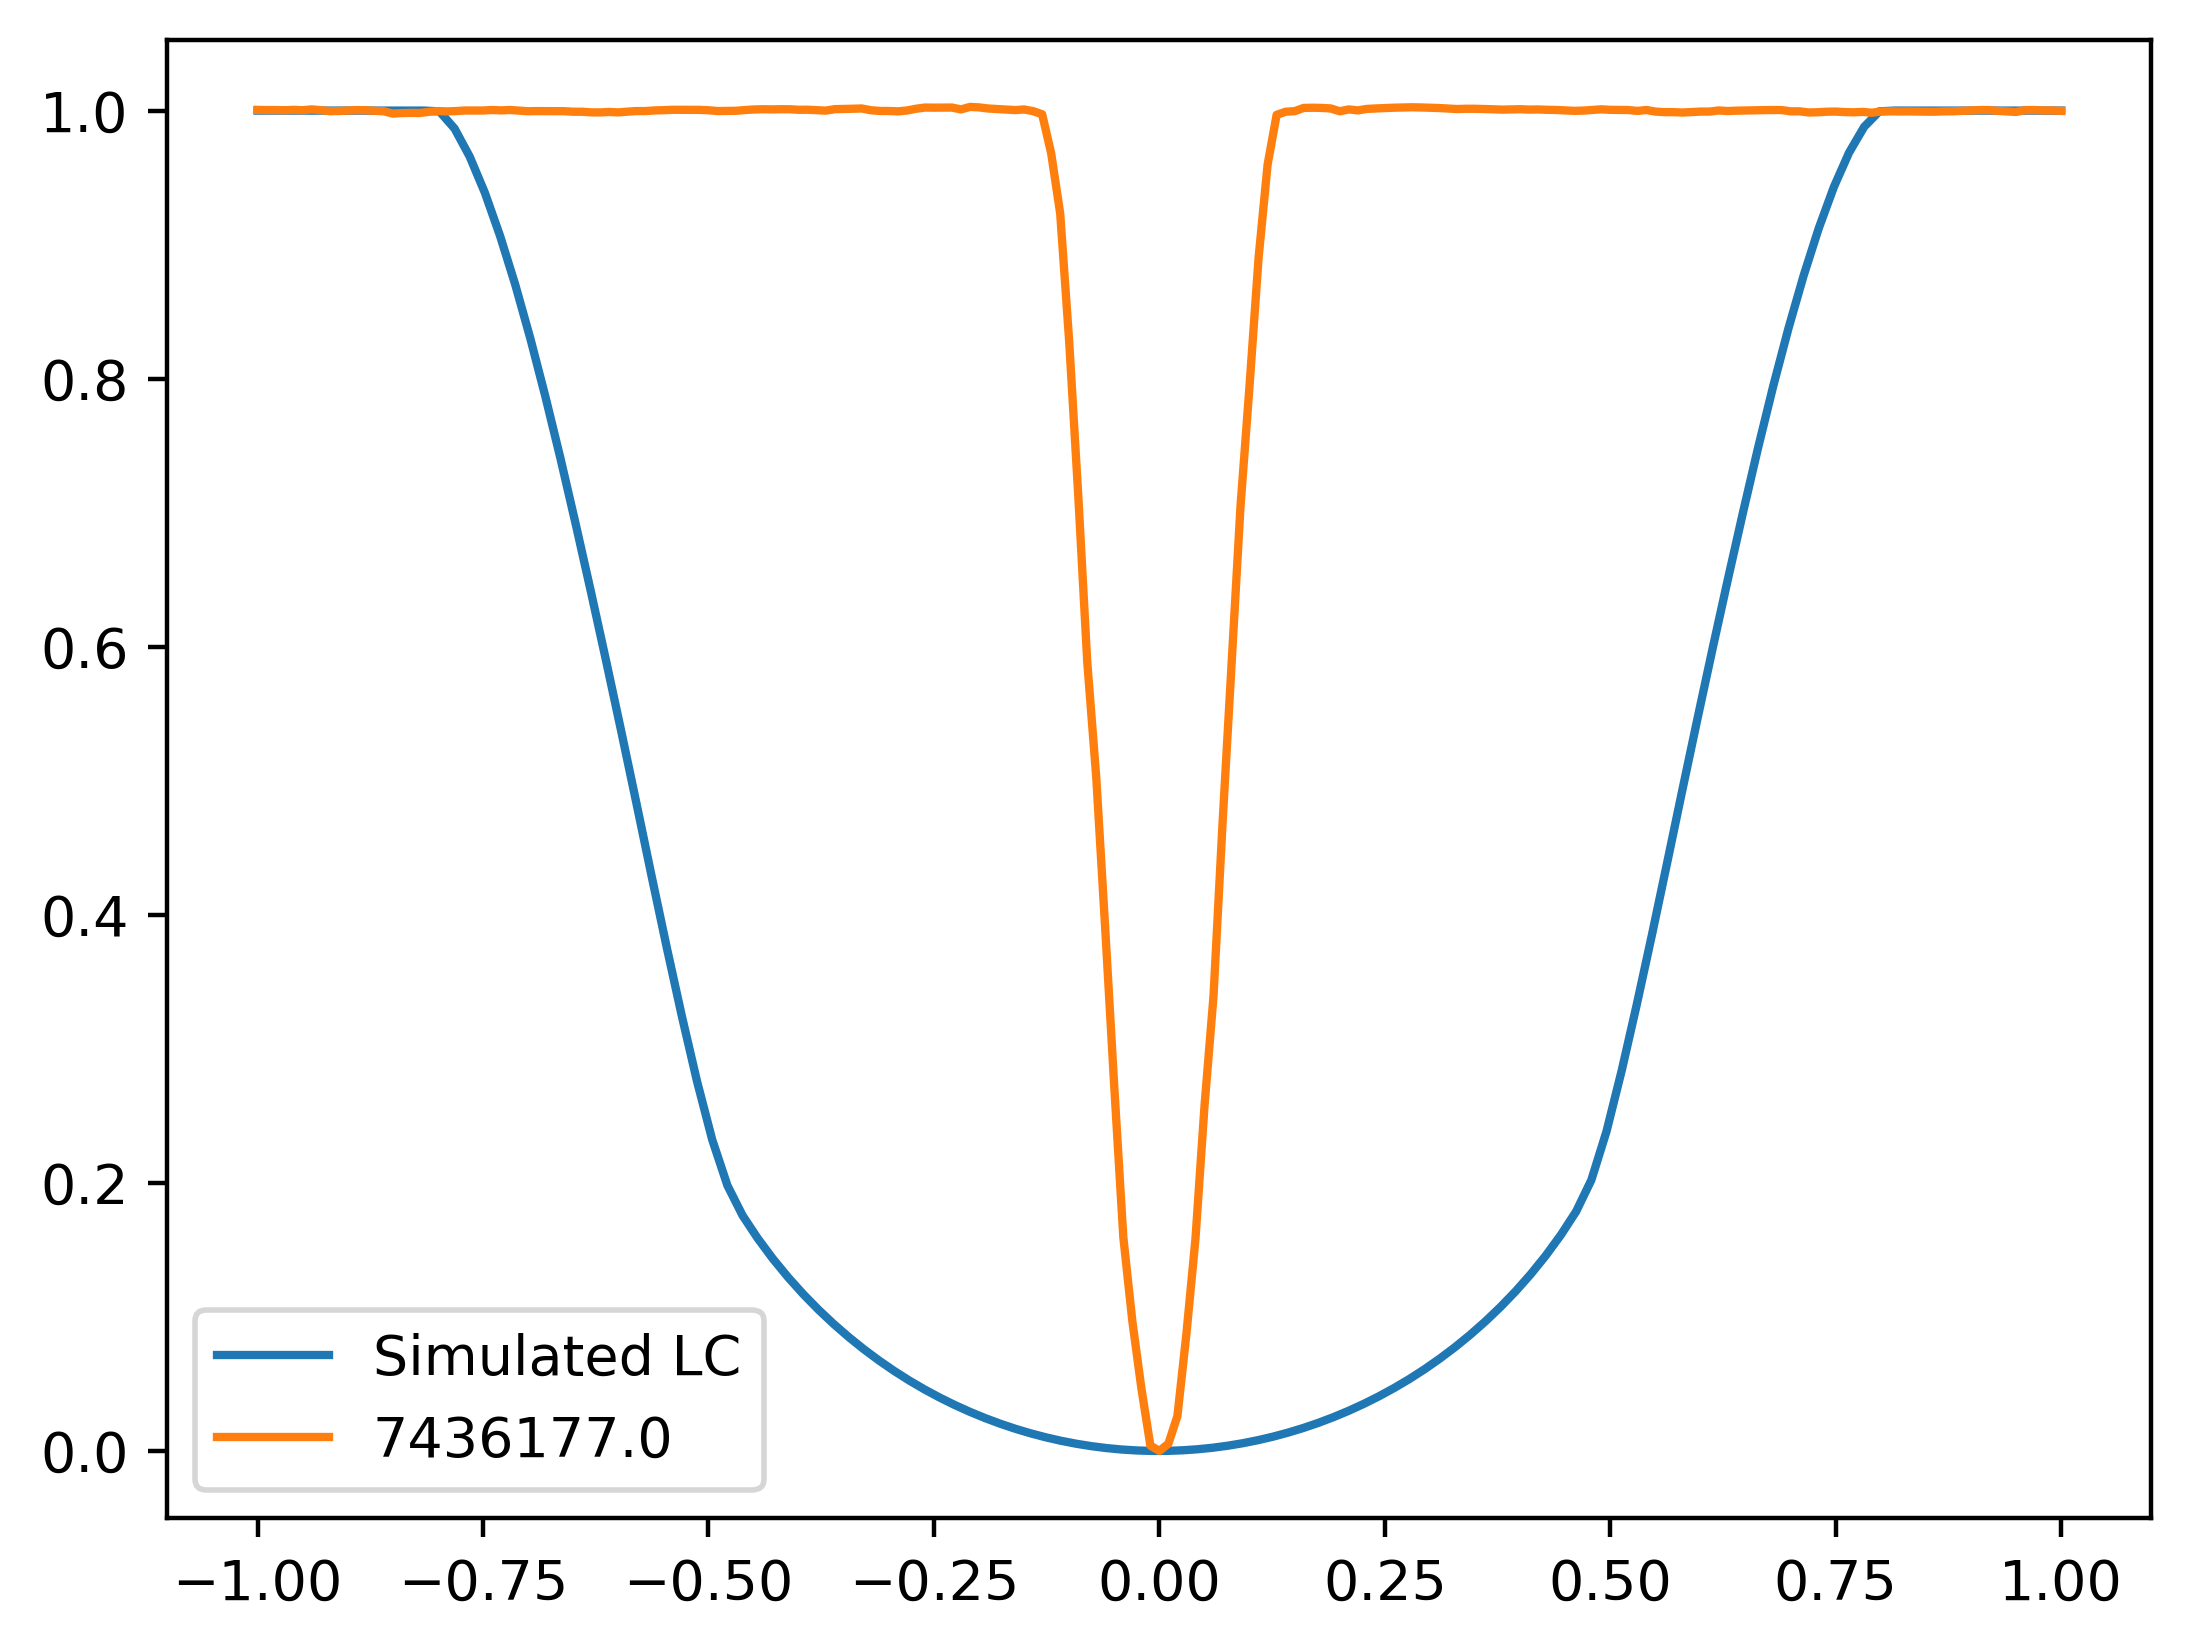

In [110]:
plt.plot(ph_simul,train_lc_scaled_append[0],label='Simulated LC')
plt.plot(ph_kepler,local_view_array[selected_kepler_index[25]],label=f"{kepid_array[selected_kepler_index[25]]}")
plt.legend()
plt.show()

In [111]:
# lc_np_array_offset_mask used to select the flat part by certain percentage
local_view_array_mask = np.copy(local_view_array)

for iter in np.arange(len(local_view_array_mask)):
    # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
    local_view_array_mask[iter][(local_view_array_mask[iter]>=0.98)] = 1.0
    local_view_array_mask[iter][(local_view_array_mask[iter]<0.98)] = 0.0

print("Length of one Kepler LC = ",len(local_view_array_mask[0]))


Length of one Kepler LC =  201


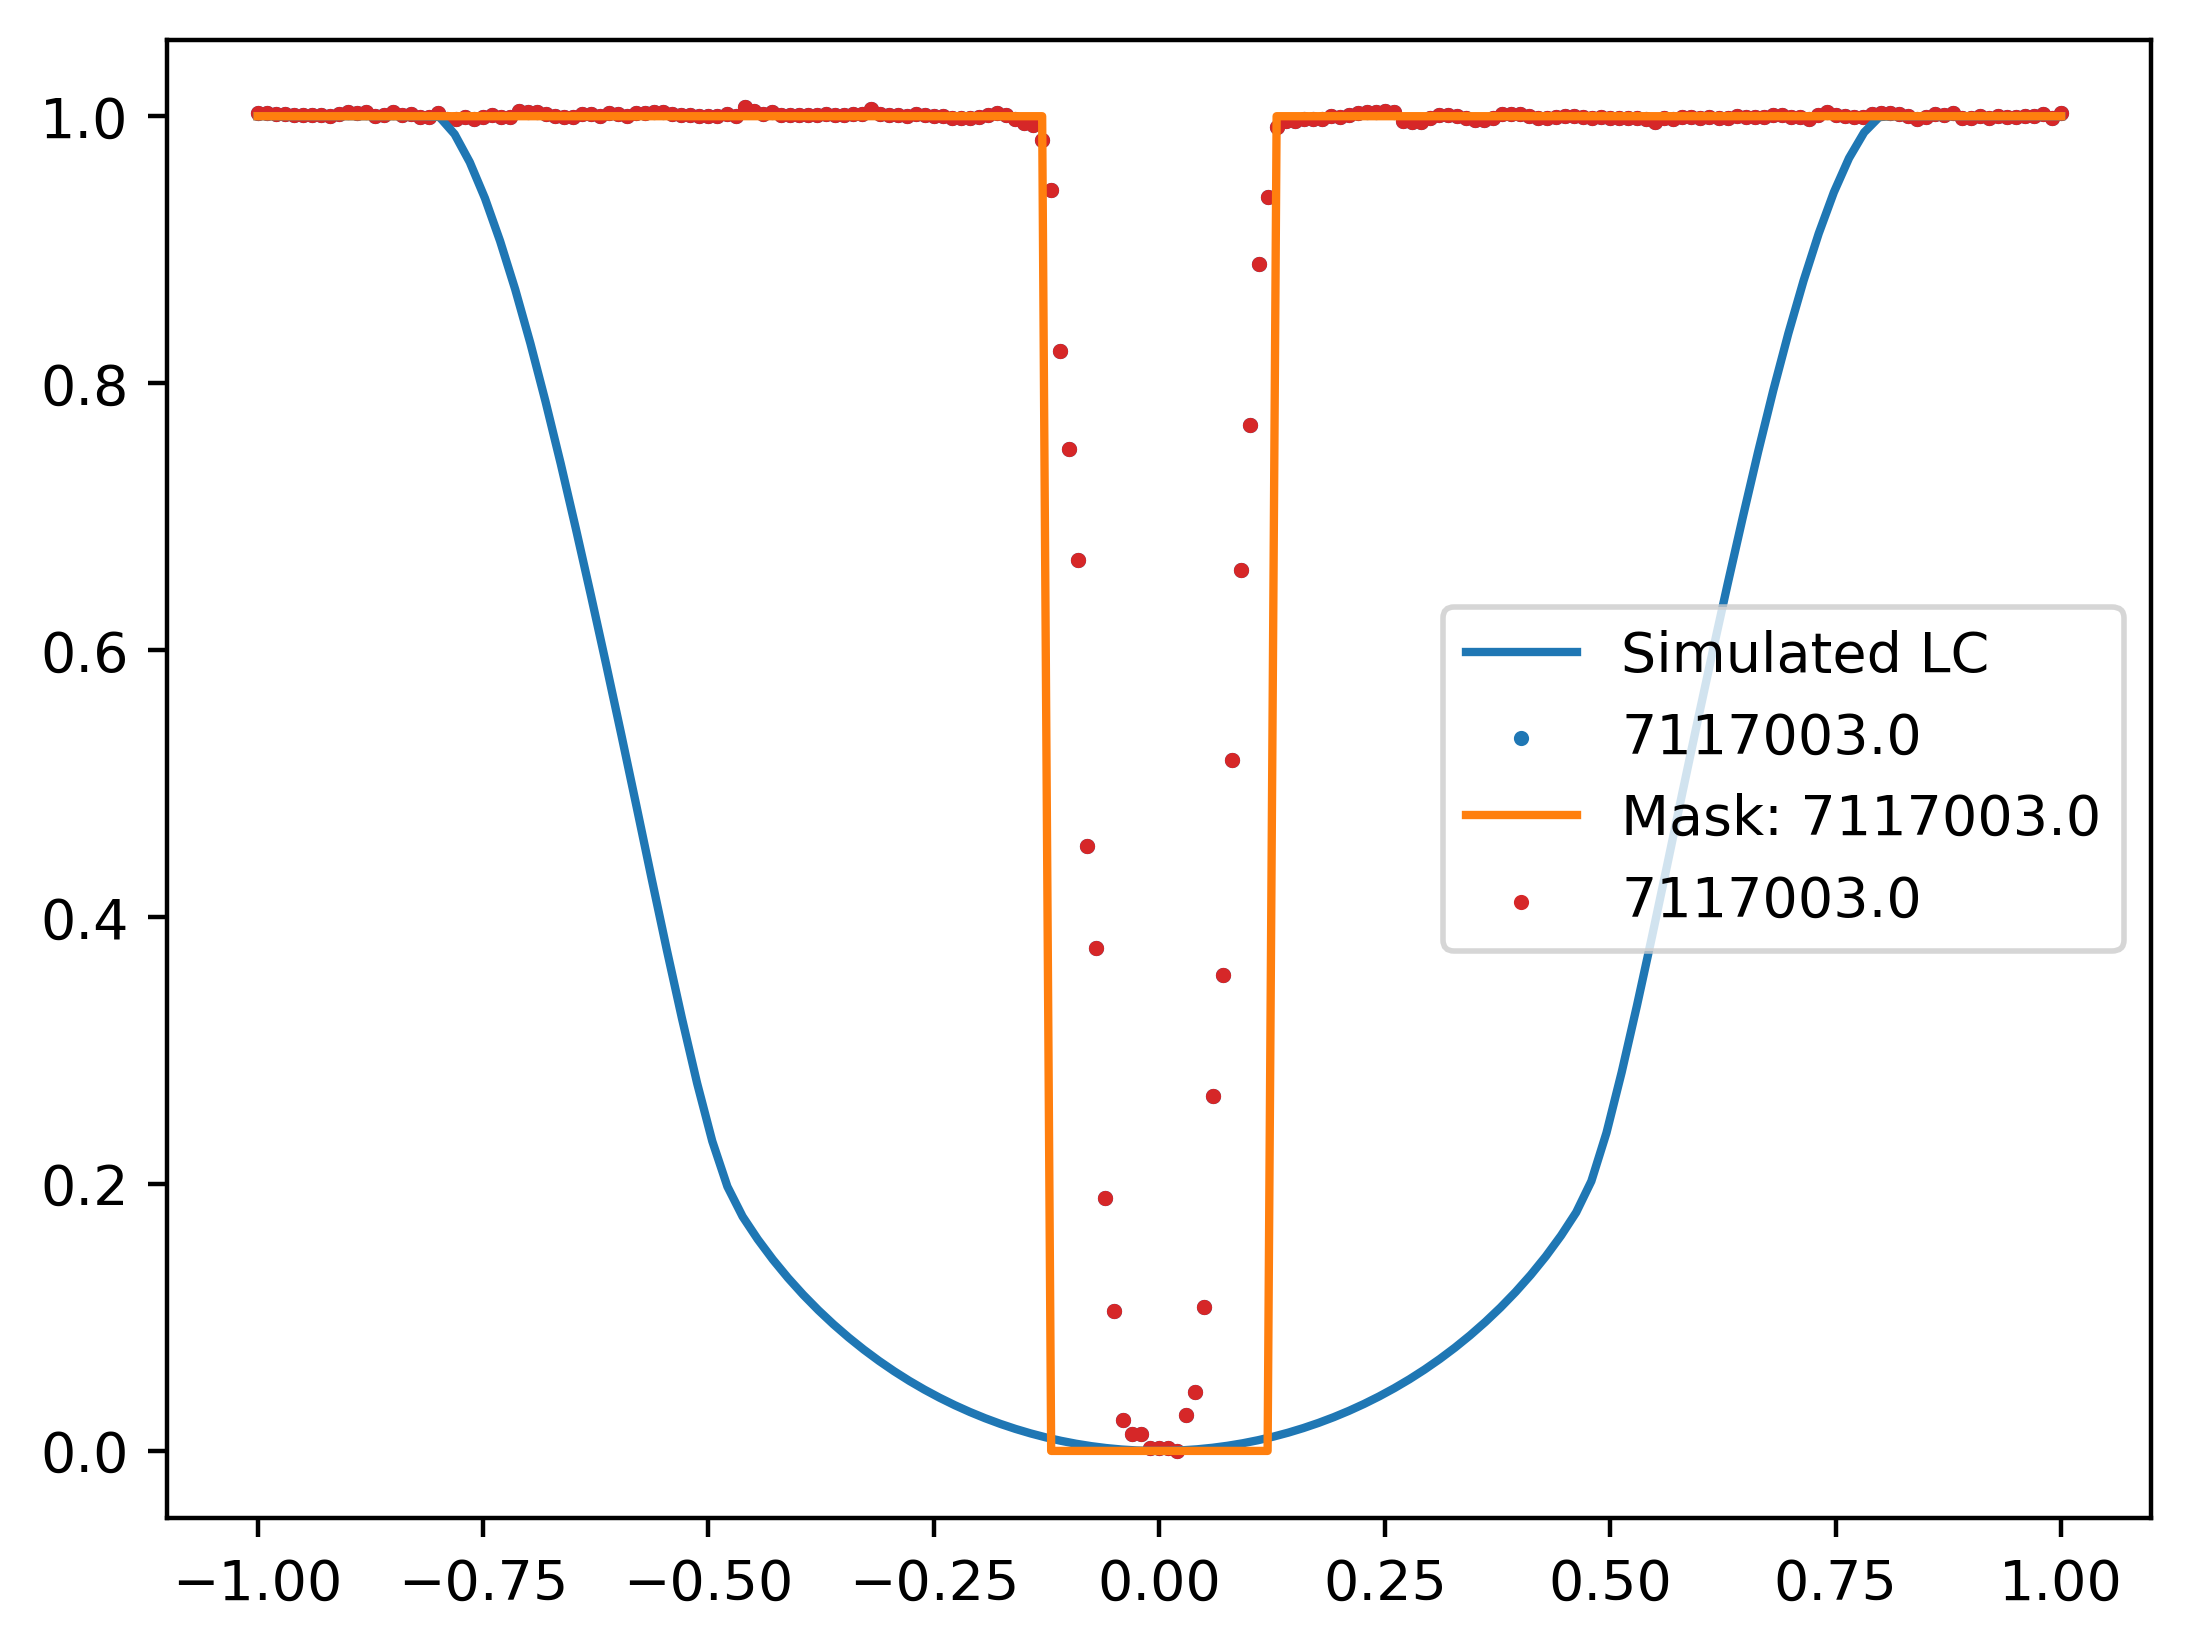

In [112]:
plt.plot(ph_simul,train_lc_scaled_append[0],label='Simulated LC')
plt.scatter(ph_kepler,local_view_array[selected_kepler_index[0]],label=f"{kepid_array[selected_kepler_index[0]]}",s=3)
plt.plot(ph_kepler,local_view_array_mask[selected_kepler_index[0]],label=f"Mask: {kepid_array[selected_kepler_index[0]]}")

# Experimenting with select center region
plt.scatter(ph_kepler,local_view_array[selected_kepler_index[0]][:],label=f"{kepid_array[selected_kepler_index[0]]}",s=3,color='tab:red')


plt.legend()
plt.show()

# Step I: Selecting left and right side by fixed amount for all cases

In [113]:
horiz_select = 30
print("No. of 1's to include in each side = ",horiz_select)

center_index = int(len(local_view_array[0])/2)
print("center_index = ",center_index)
# Select 20 elements to the right and left of the center_index
left_index = int(center_index - horiz_select) 
right_index = int(center_index + horiz_select)

print('left_index = ',left_index)
print('right_index = ',right_index)

local_view_array_center = np.zeros((len(local_view_array),len(local_view_array[0][left_index:right_index+1])))
print(local_view_array_center.shape)

No. of 1's to include in each side =  30
center_index =  100
left_index =  70
right_index =  130
(15737, 61)


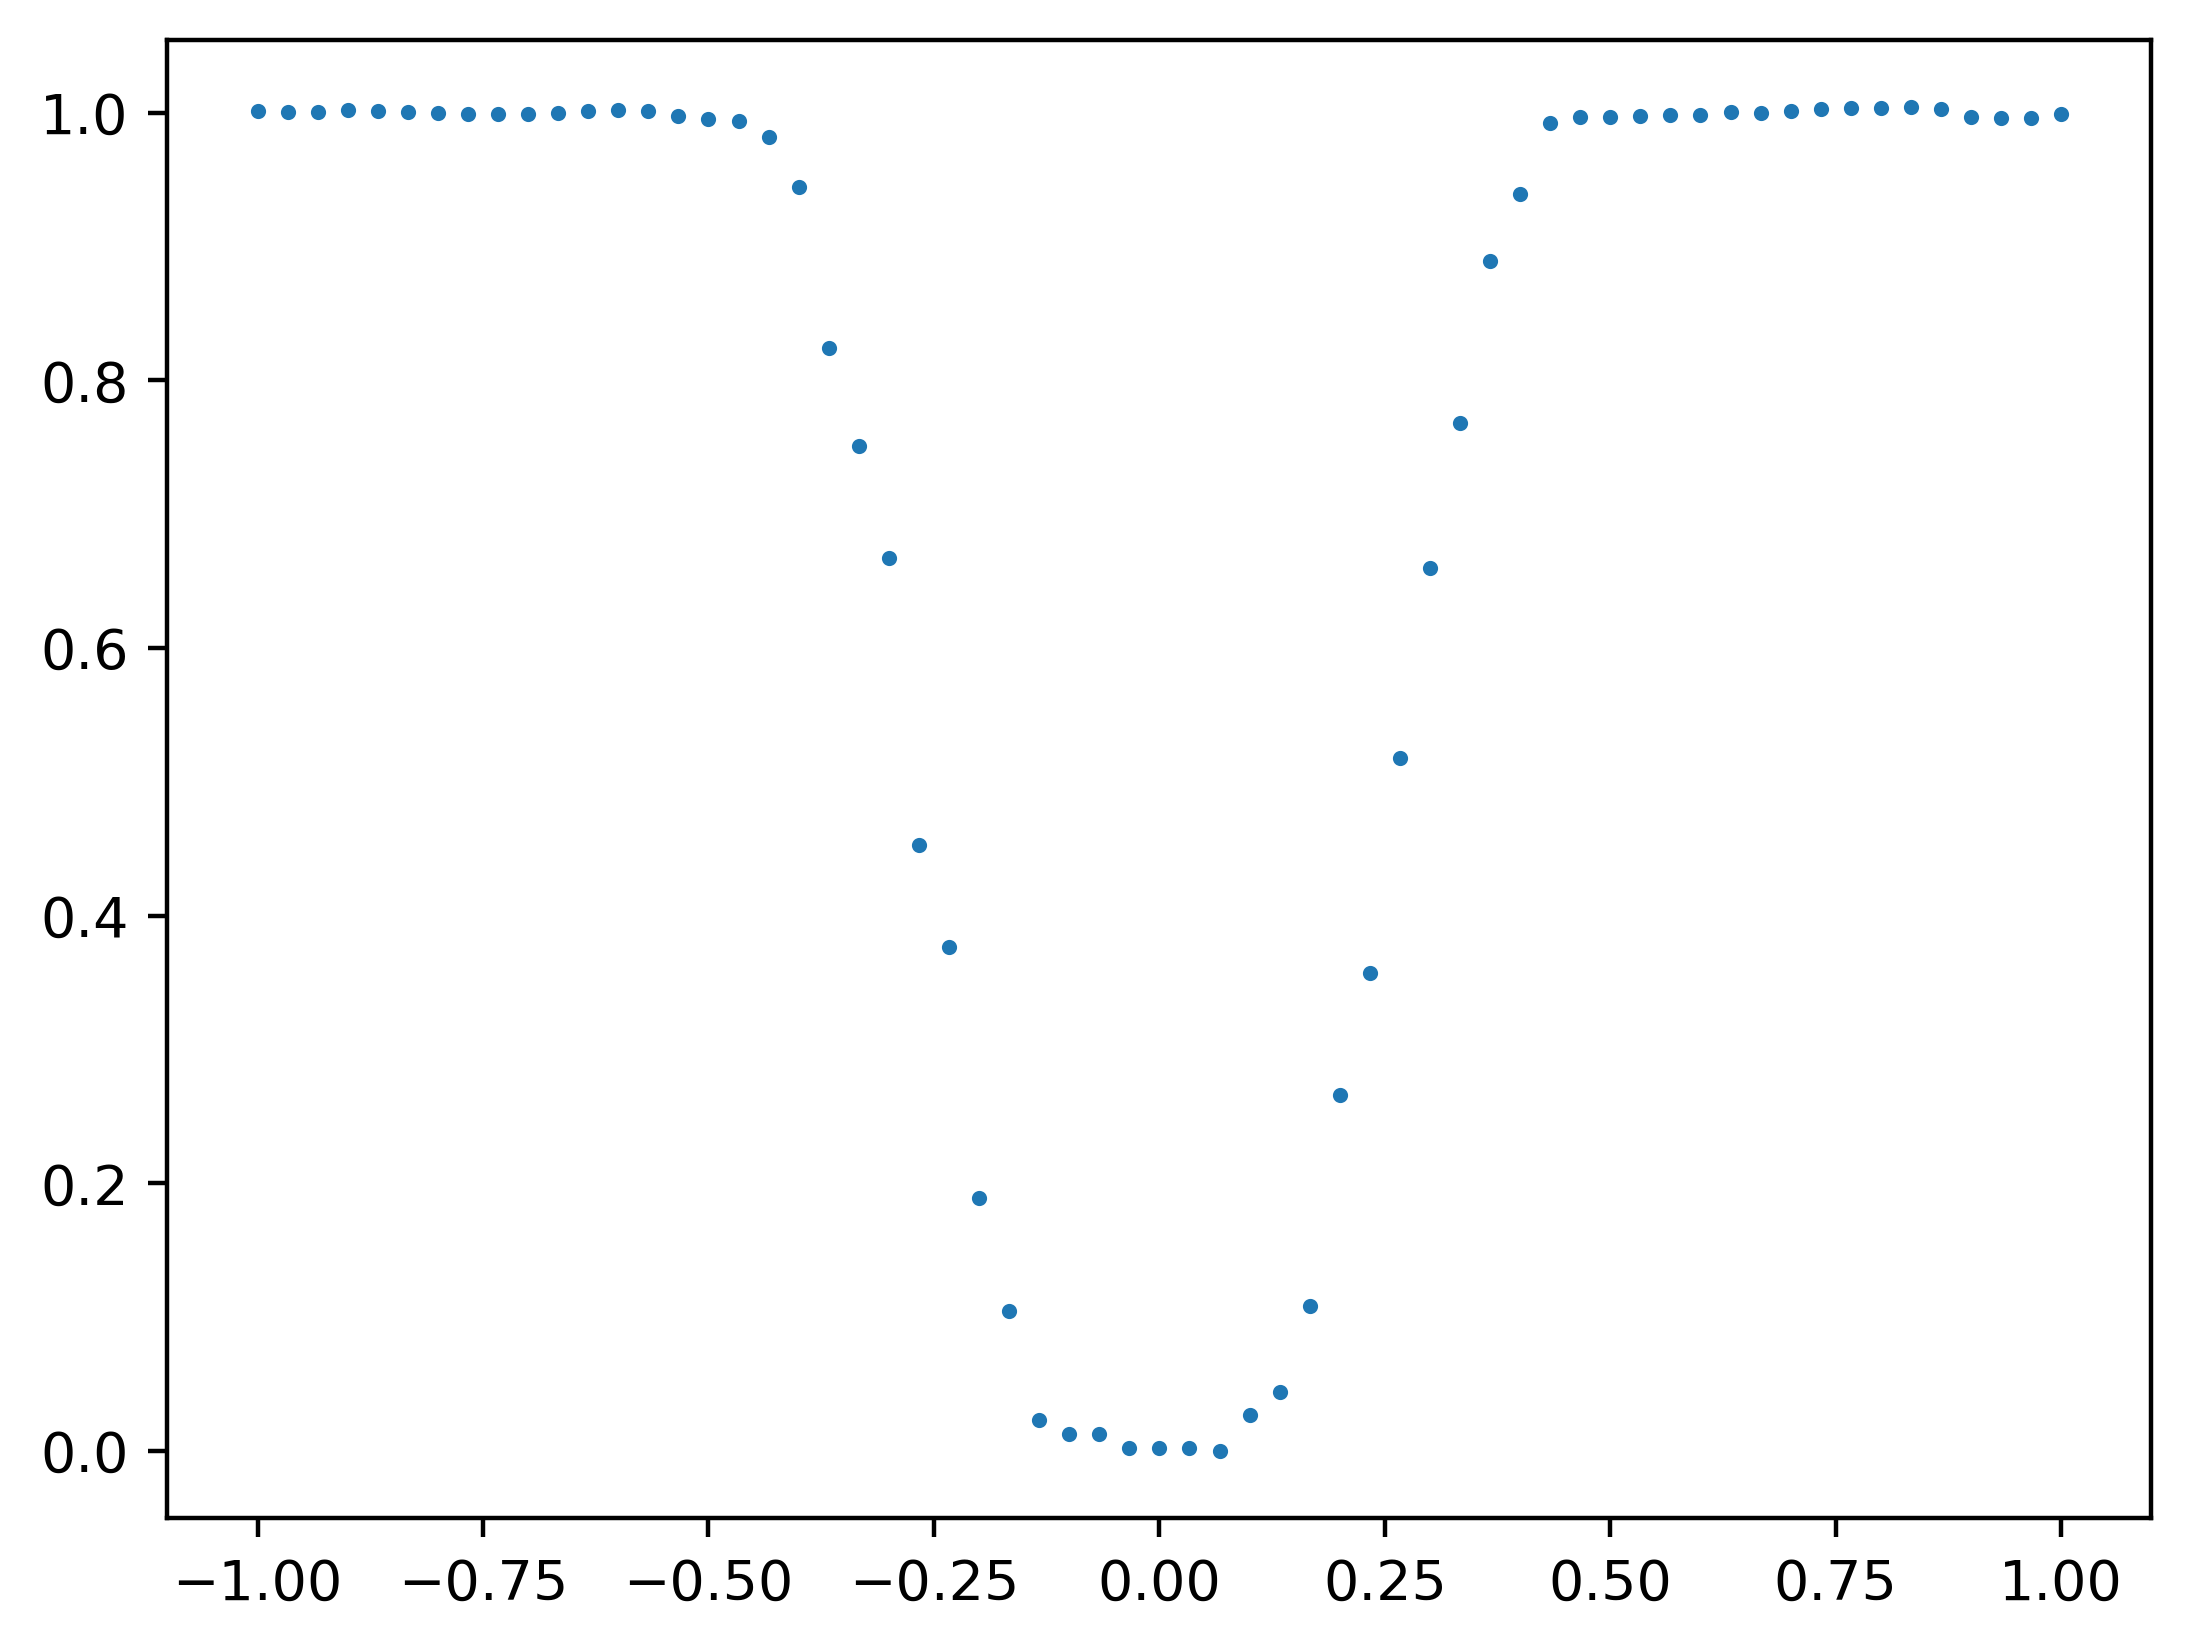

In [114]:
# Test plot of a selection
lc_test=local_view_array[selected_kepler_index[0]][left_index:right_index+1]
plt.scatter(np.linspace(-1,1,len(lc_test)),lc_test,s=3)
plt.show()

In [115]:
for iteration in np.arange(len(local_view_array)):   


    # Use array slicing to select the elements
    selected_portion = local_view_array[iteration][left_index:right_index+1]
    # selected_portion_mask = local_view_array_mask[iteration][left_index:right_index + 1]

    local_view_array_center[iteration] = selected_portion
print('len_of_selected_portion = ',len(selected_portion))

len_of_selected_portion =  61


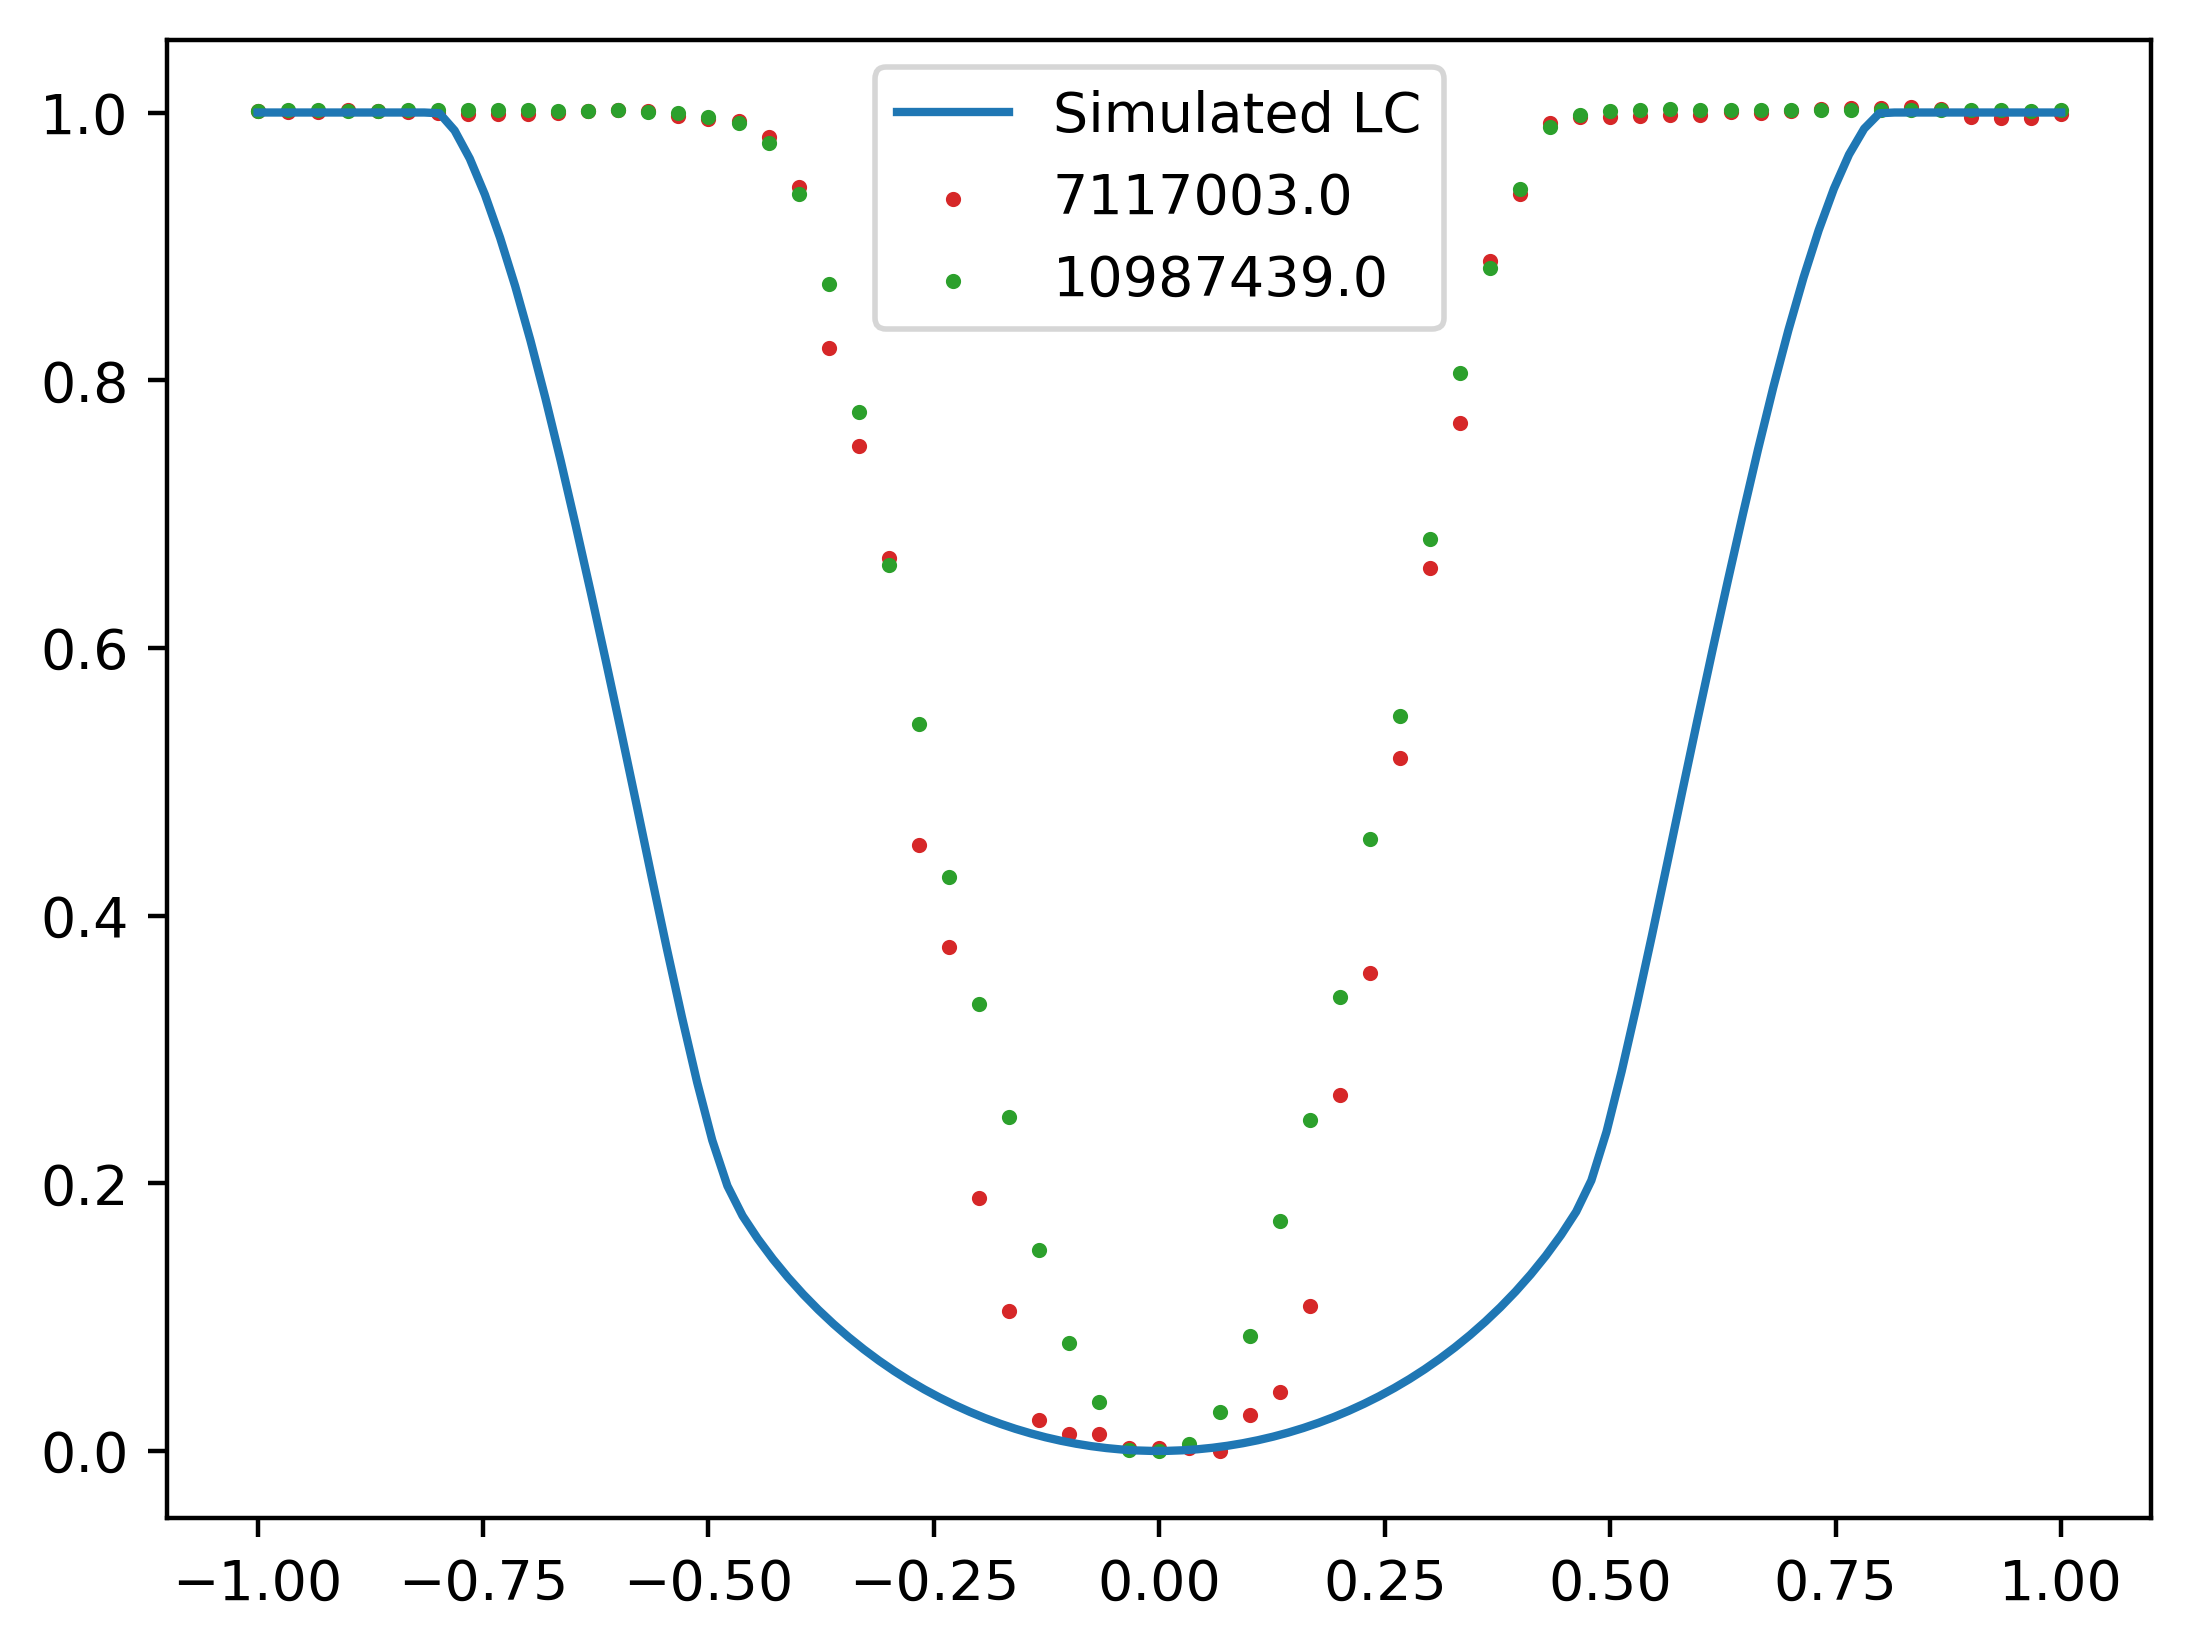

In [116]:
plt.plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC')
# plt.scatter(ph_kepler,local_view_array[selected_kepler_index[100]],label=f"{kepid_array[selected_kepler_index[0]]}",s=3)
# plt.plot(ph_kepler,local_view_array_mask[selected_kepler_index[0]],label=f"Mask: {kepid_array[selected_kepler_index[0]]}")

# Experimenting with select center region
plt.scatter(np.linspace(-1,1,len(local_view_array_center[0])),local_view_array_center[selected_kepler_index[0]],label=f"{kepid_array[selected_kepler_index[0]]}",s=3,color='tab:red')
plt.scatter(np.linspace(-1,1,len(local_view_array_center[0])),local_view_array_center[selected_kepler_index[2]],label=f"{kepid_array[selected_kepler_index[2]]}",s=3,color='tab:green')


plt.legend()
plt.show()

# STep II: Selecting left and right side by certain percentage

In [117]:
count_zeros_array = np.zeros((len(local_view_array),))
for iteration in np.arange(len(local_view_array)):
    # Calculate the number of occurrences of '0'
    count_zeros = np.count_nonzero(local_view_array_mask[iteration] == 0)  
    count_zeros_array[iteration] = count_zeros




center_index =  100
selected_kepler_index_elem =  15022


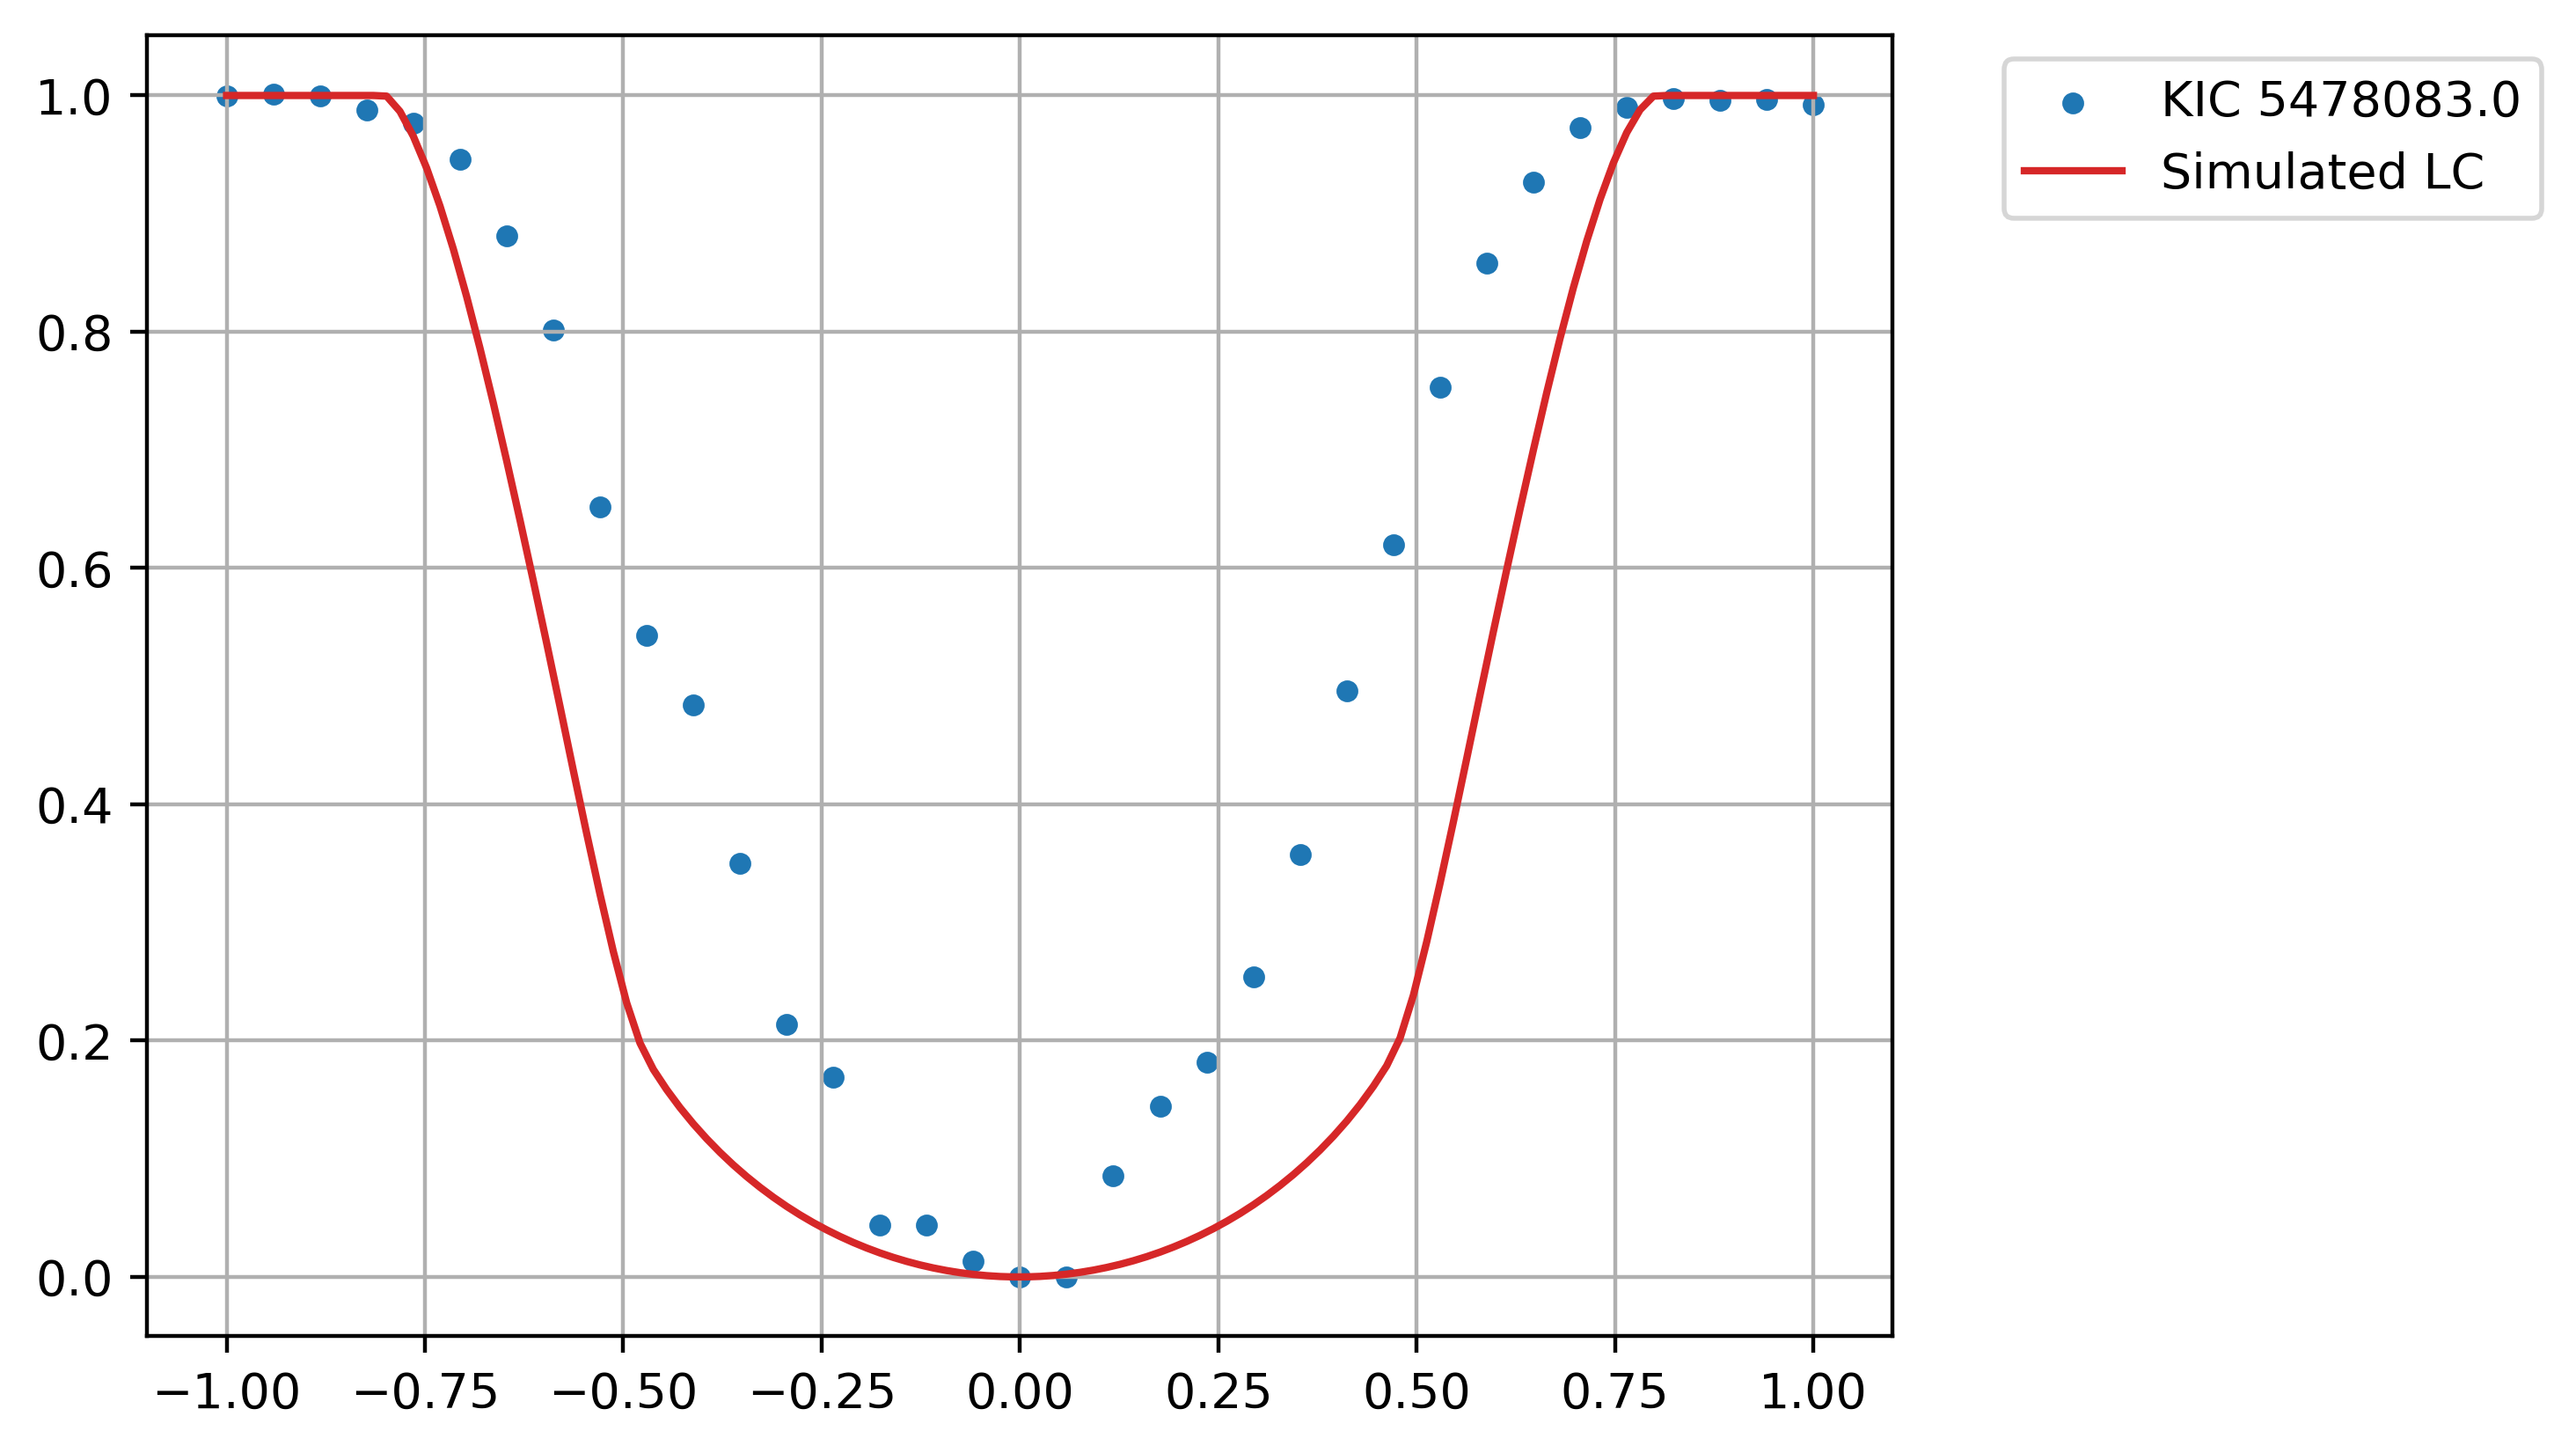

In [118]:
center_index = int(len(local_view_array[0])/2)
print("center_index = ",center_index)

# Create a figure and axis
fig, ax = plt.subplots()

for iteration in np.arange(1):
    # selected_kepler_index_elem = selected_kepler_index[iteration]
    selected_kepler_index_elem = np.random.choice(selected_kepler_index)
    print('selected_kepler_index_elem = ',selected_kepler_index_elem)
    left_index = int(center_index - int(count_zeros_array[selected_kepler_index_elem]/2)-int(count_zeros_array[selected_kepler_index_elem]/6)) 
    right_index = int(center_index + int(count_zeros_array[selected_kepler_index_elem]/2)+int(count_zeros_array[selected_kepler_index_elem]/6))
    # print("left_index = ",left_index)
    # print("right_index = ",right_index)
    lc_test=local_view_array[selected_kepler_index_elem][left_index:right_index+1]
    ax.scatter(np.linspace(-1,1,len(lc_test)),lc_test,s=12,label=f"KIC {kepid_array[selected_kepler_index_elem]}")
    # ax.plot(np.linspace(-1,1,len(lc_test)),lc_test)
ax.plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:red")
# ax.scatter(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:red",s=1)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid('on')
plt.show()


center_index =  100
selected_kepler_index_elem =  5524
selected_kepler_index_elem =  938
selected_kepler_index_elem =  3337
selected_kepler_index_elem =  6436
selected_kepler_index_elem =  10953
selected_kepler_index_elem =  3373
selected_kepler_index_elem =  13548
selected_kepler_index_elem =  10342
selected_kepler_index_elem =  8781
selected_kepler_index_elem =  5044
selected_kepler_index_elem =  7703
selected_kepler_index_elem =  1148
selected_kepler_index_elem =  7529
selected_kepler_index_elem =  5662
selected_kepler_index_elem =  10097


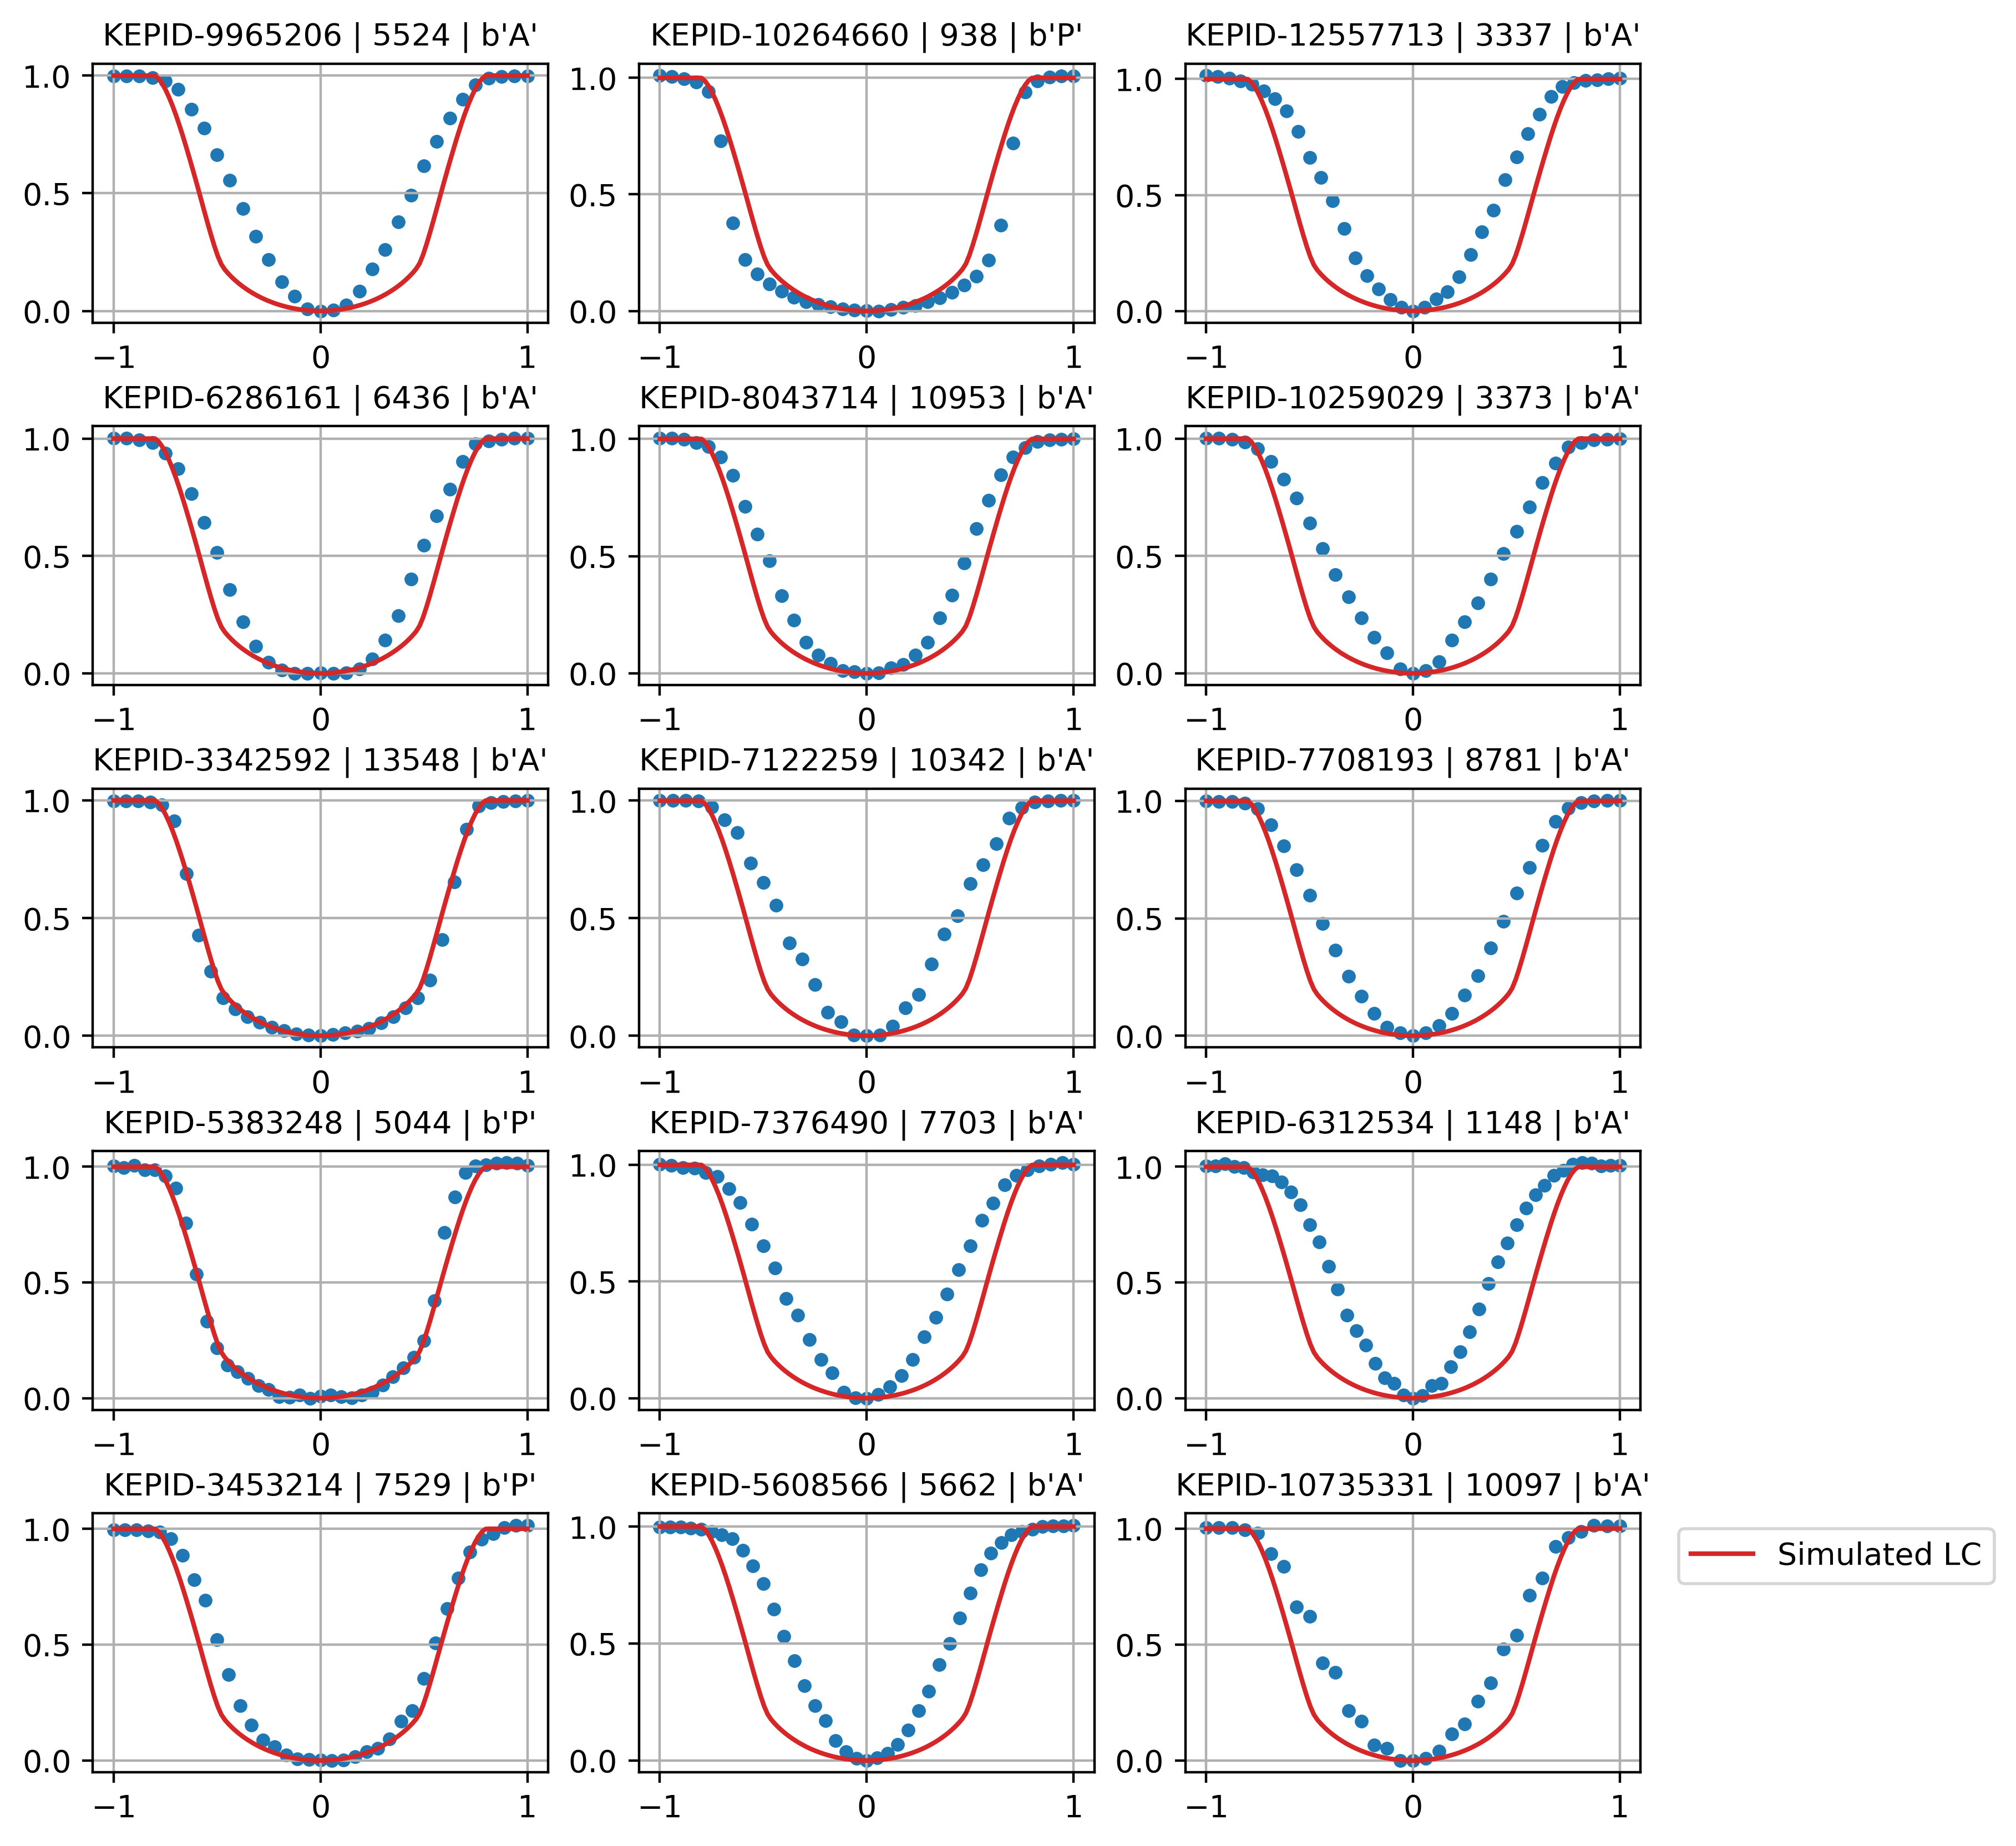

In [119]:
center_index = int(len(local_view_array[0])/2)
print("center_index = ",center_index)

num = 5
# Create a figure and axis
fig, ax = plt.subplots(num,3, figsize=(9,10), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400


for iteration in range(num):

    ax[iteration][0].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],color="tab:red")
    ax[iteration][1].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],color="tab:red")
    ax[iteration][2].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:red")
    
    ax[iteration][0].grid('on')
    ax[iteration][1].grid('on')
    ax[iteration][2].grid('on')

    for inner_iteration in np.arange(3):
        selected_kepler_index_elem = np.random.choice(selected_kepler_index)
        print('selected_kepler_index_elem = ',selected_kepler_index_elem)
        left_index = int(center_index - int(count_zeros_array[selected_kepler_index_elem]/2)-int(count_zeros_array[selected_kepler_index_elem]/6)) 
        right_index = int(center_index + int(count_zeros_array[selected_kepler_index_elem]/2)+int(count_zeros_array[selected_kepler_index_elem]/6))
        # print("left_index = ",left_index)
        # print("right_index = ",right_index)
        lc_test=local_view_array[selected_kepler_index_elem][left_index:right_index+1]
        ax[iteration][inner_iteration].scatter(np.linspace(-1,1,len(lc_test)),lc_test,s=12)
        ax[iteration][inner_iteration].set_title(f"KEPID-{int(kepid_array[selected_kepler_index_elem])} | {selected_kepler_index_elem} | {av_training_set_array[selected_kepler_index_elem]}",size=10)


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid('on')
plt.show()

center_index =  100
selected_kepler_index_elem =  36


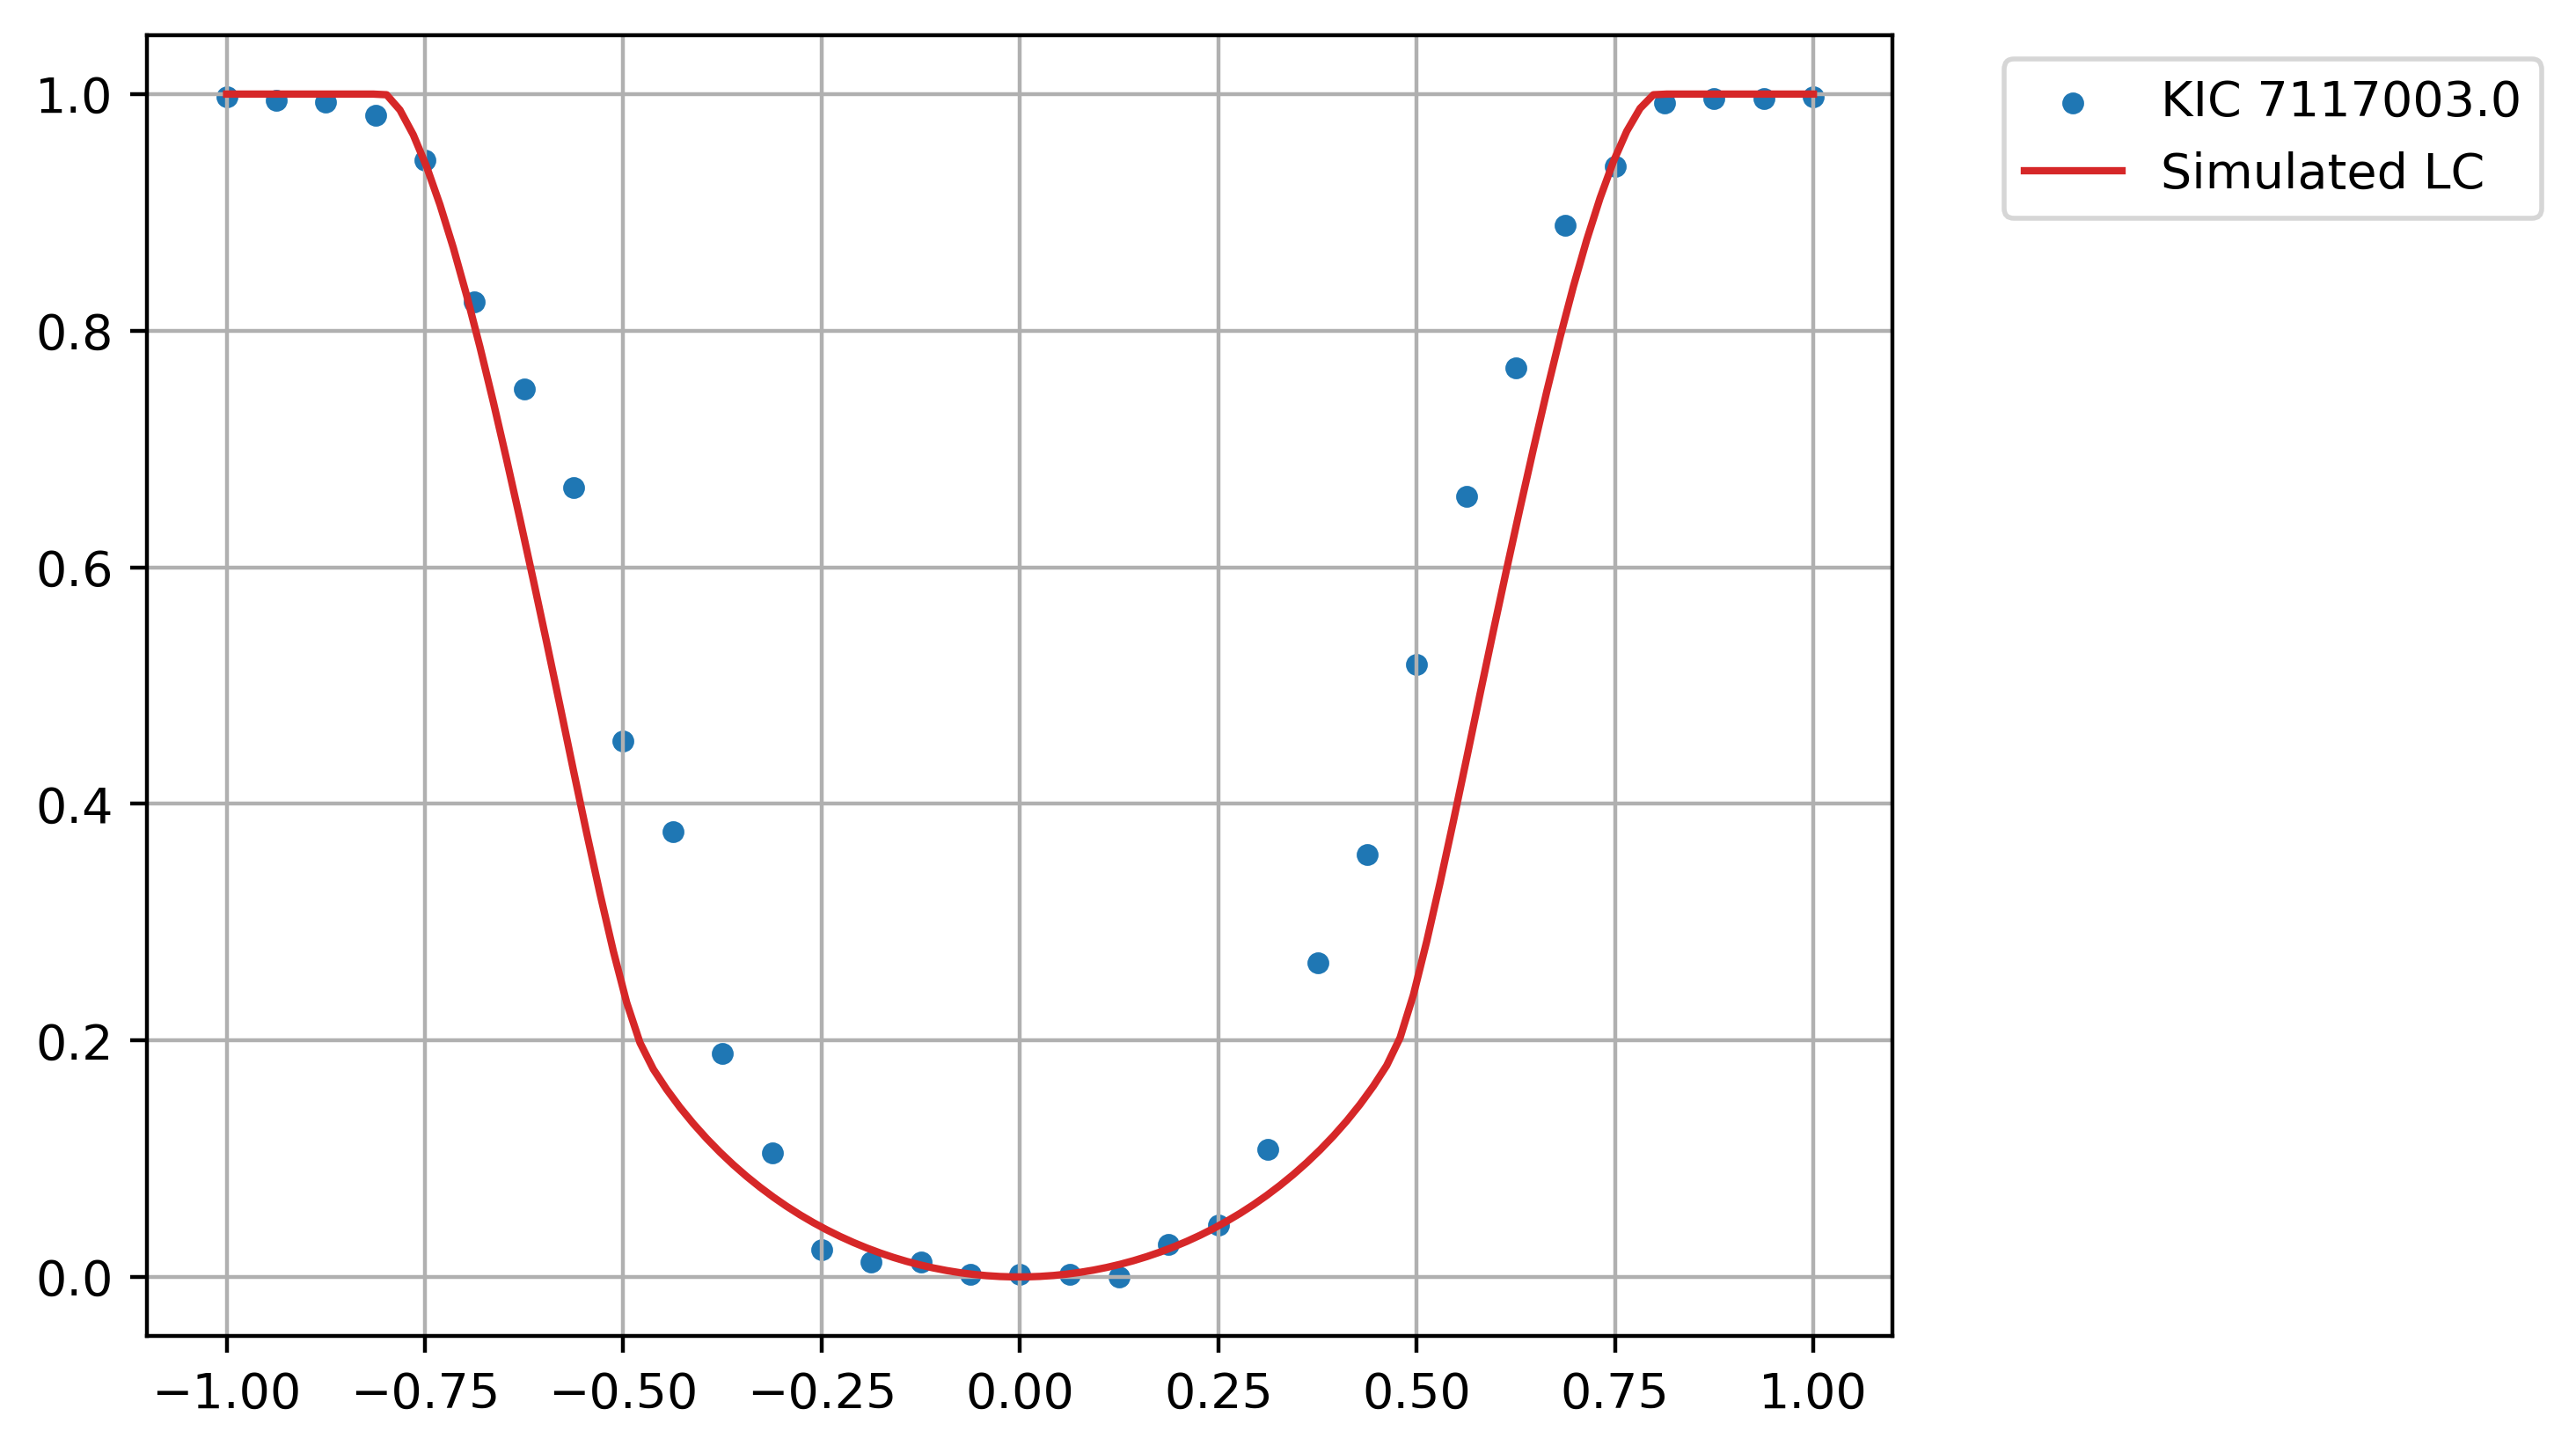

In [120]:
center_index = int(len(local_view_array[0])/2)
print("center_index = ",center_index)

# Create a figure and axis
fig, ax = plt.subplots()

for iteration in np.arange(1):
    selected_kepler_index_elem = selected_kepler_index[iteration]
    # selected_kepler_index_elem = np.random.choice(selected_kepler_index)
    print('selected_kepler_index_elem = ',selected_kepler_index_elem)
    left_index = int(center_index - int(count_zeros_array[selected_kepler_index_elem]/2)-int(count_zeros_array[selected_kepler_index_elem]/6)) 
    right_index = int(center_index + int(count_zeros_array[selected_kepler_index_elem]/2)+int(count_zeros_array[selected_kepler_index_elem]/6))
    # print("left_index = ",left_index)
    # print("right_index = ",right_index)
    lc_test=local_view_array[selected_kepler_index_elem][left_index:right_index+1]
    ax.scatter(np.linspace(-1,1,len(lc_test)),lc_test,s=12,label=f"KIC {kepid_array[selected_kepler_index_elem]}")
    # ax.plot(np.linspace(-1,1,len(lc_test)),lc_test)
ax.plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:red")
# ax.scatter(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:red",s=1)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid('on')
plt.show()


(15737, 120)


center_index =  100


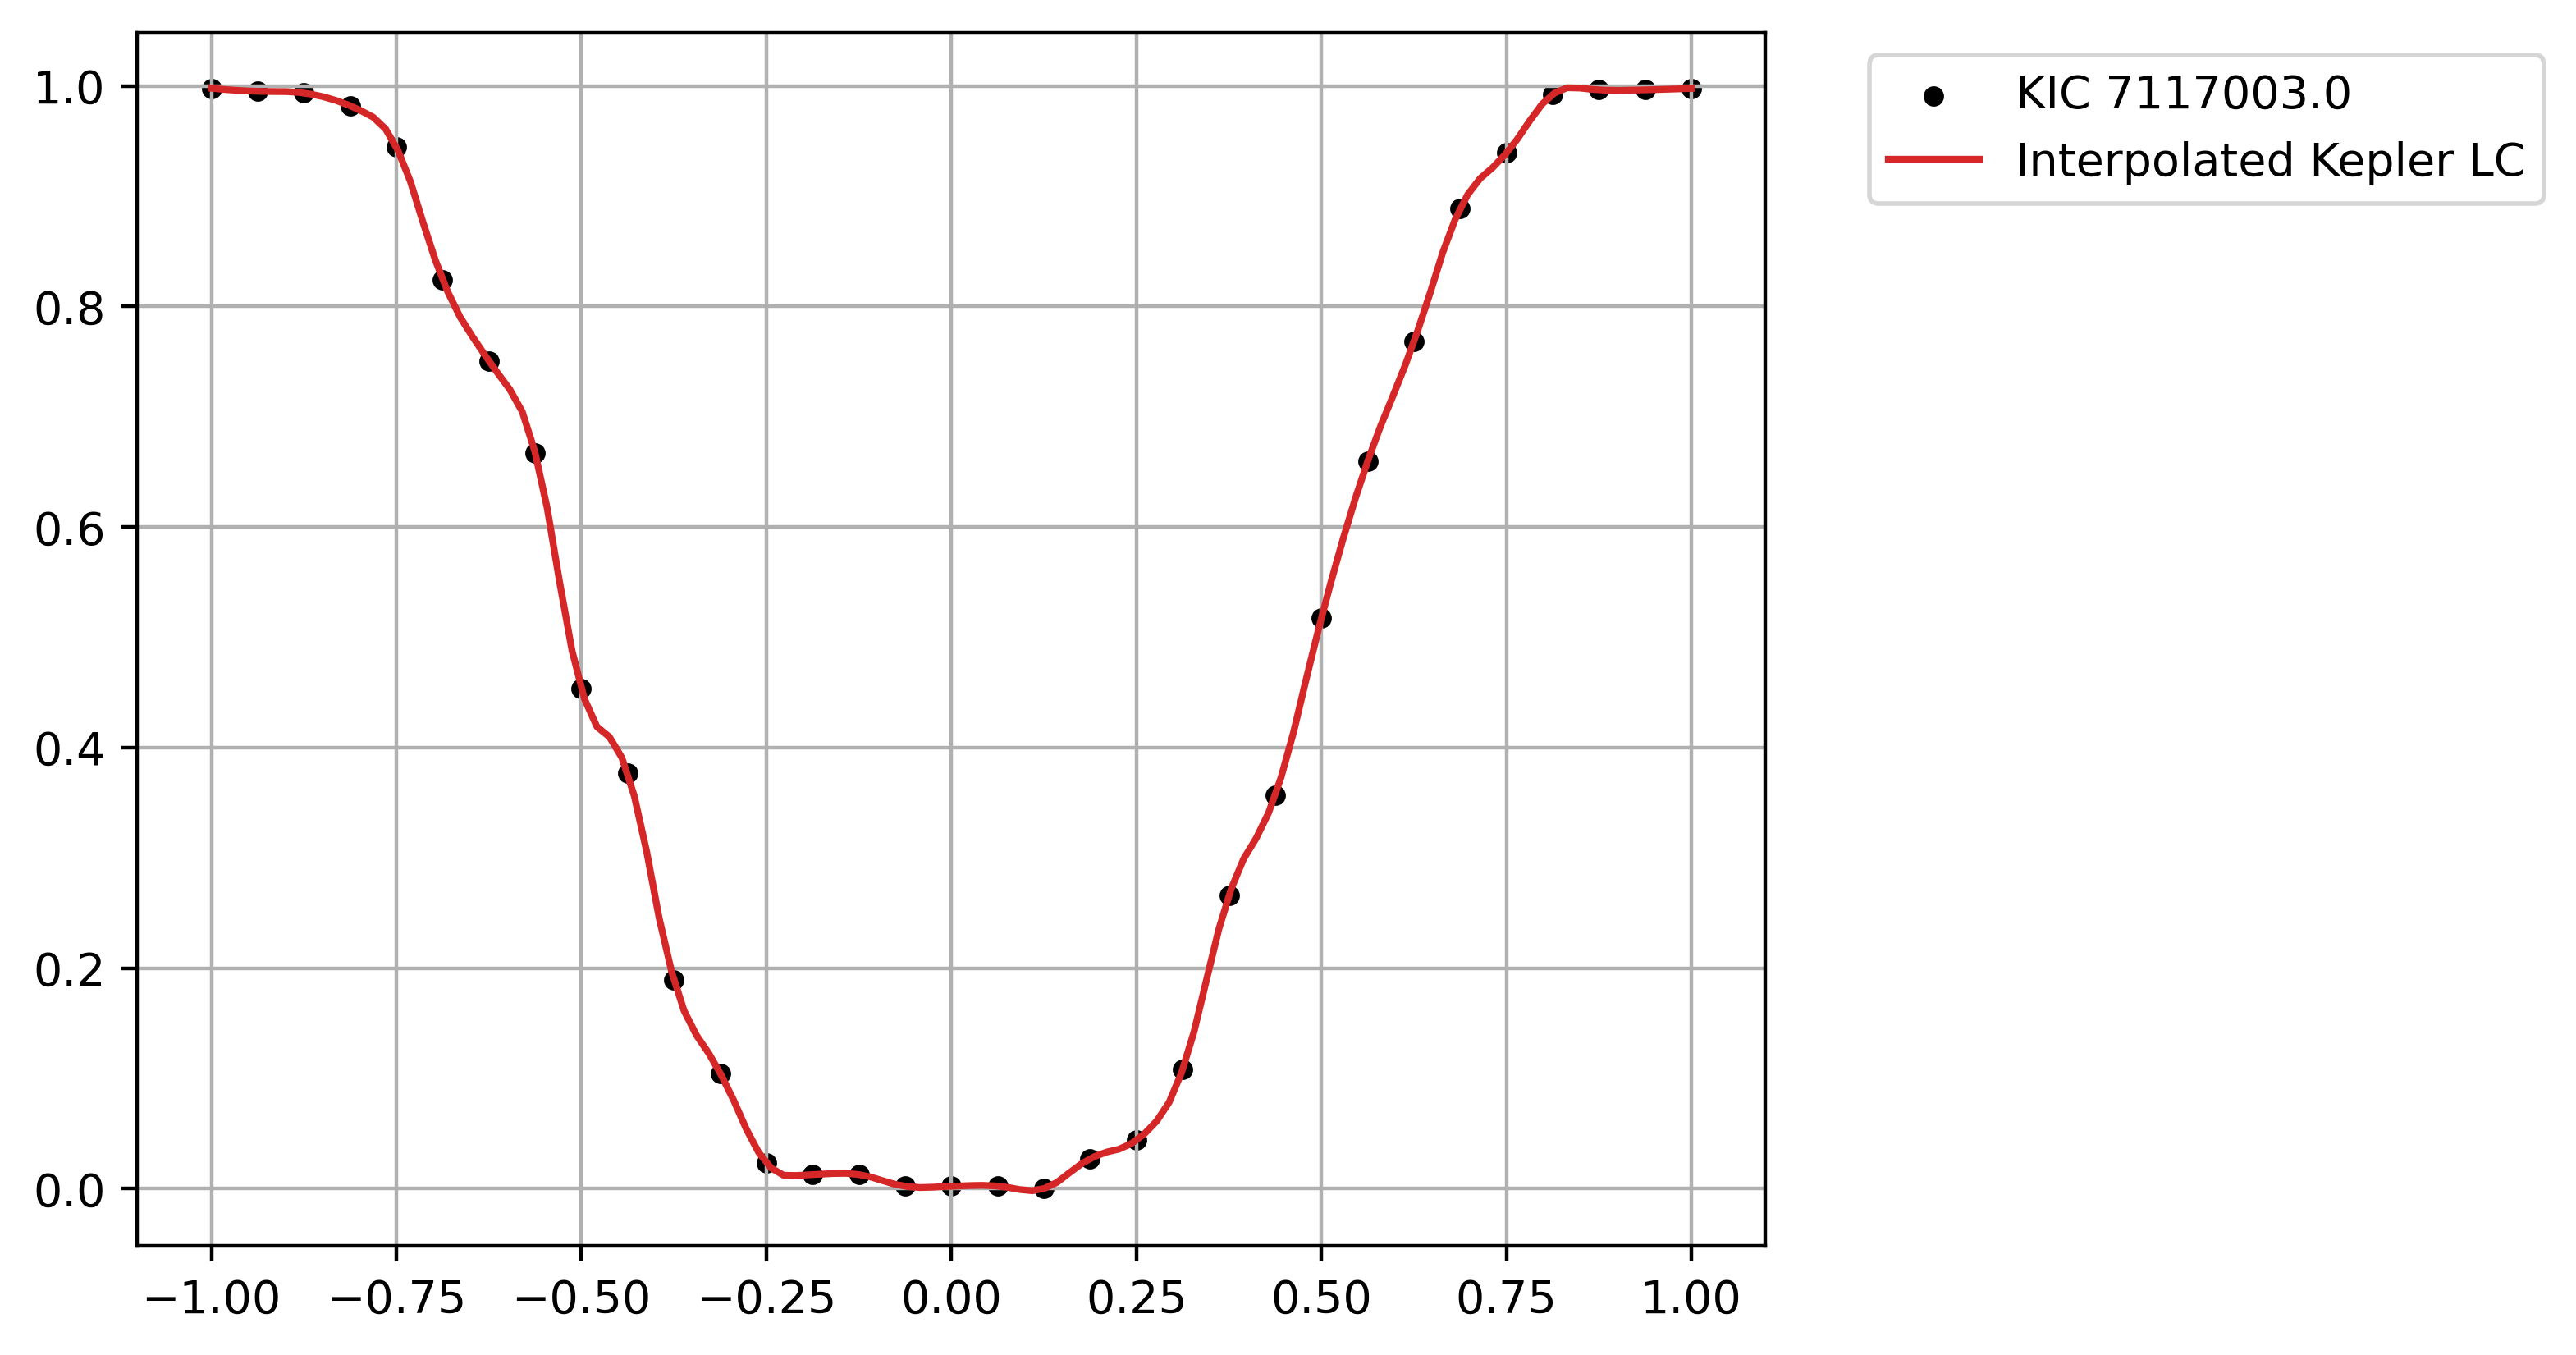

In [121]:
# Interpolate the Kepler light curve
local_view_array_interpol = np.zeros((len(local_view_array),len(train_lc_scaled_append[0])))
len_selected_portion = np.zeros(len(local_view_array))
print(local_view_array_interpol.shape)
for iteration in np.arange(len(local_view_array_interpol)):
    
    
    left_index = int(center_index - int(count_zeros_array[iteration]/2)-int(count_zeros_array[iteration]/6)) 
    right_index = int(center_index + int(count_zeros_array[iteration]/2)+int(count_zeros_array[iteration]/6))
    selected_portion = local_view_array[iteration][left_index:right_index+1]
    
    # Calculate the length of the selected region
    len_selected_portion[iteration] = len(selected_portion)

    # Interpolate the selected portion
    # Original data with 30 elements
    original_x = np.linspace(-1, 1, num=len(selected_portion))
    original_y = selected_portion  

    # Create a quadratic interpolation function
    f = interp1d(original_x, original_y, kind='quadratic')

    # Define the range of x-values for the interpolation with 120 elements
    x_interpolation = np.linspace(-1, 1, num=len(train_lc_scaled_append[0]))

    # Perform the interpolation
    y_interpolated = f(x_interpolation)
    local_view_array_interpol[iteration] = y_interpolated


# Plot original data points and interpolated Kepler light curve on top of each other
center_index = int(len(local_view_array[0])/2)
print("center_index = ",center_index)

# Create a figure and axis
fig, ax = plt.subplots()

for iteration in np.arange(1):
    selected_kepler_index_elem = selected_kepler_index[iteration]
    left_index = int(center_index - int(count_zeros_array[selected_kepler_index_elem]/2)-int(count_zeros_array[selected_kepler_index_elem]/6)) 
    right_index = int(center_index + int(count_zeros_array[selected_kepler_index_elem]/2)+int(count_zeros_array[selected_kepler_index_elem]/6))
    # print("left_index = ",left_index)
    # print("right_index+1 = ",right_index+1)
    lc_test=local_view_array[selected_kepler_index_elem][left_index:right_index+1]
    ax.scatter(np.linspace(-1,1,len(lc_test)),lc_test,s=12,label=f"KIC {kepid_array[selected_kepler_index_elem]}",color="black")
    ax.plot(np.linspace(-1,1,len(local_view_array_interpol[selected_kepler_index_elem])),local_view_array_interpol[selected_kepler_index_elem],color = 'tab:red',label="Interpolated Kepler LC")
    # ax.plot(np.linspace(-1,1,len(lc_test)),lc_test)
# ax.plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:green")
# ax.scatter(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:red",s=1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid('on')
plt.show()

In [122]:
print("No. selected Kepler LC = ",len(len_selected_portion[selected_kepler_index]))
print("No. selected Kepler LC = ",len(selected_kepler_index))

# Calculate the mean, median number of datapoints 
print("# Calculate the mean, median number of datapoints ")
print("median = ",np.median(len_selected_portion[selected_kepler_index]))
print("mean = ", np.mean(len_selected_portion[selected_kepler_index]))

No. selected Kepler LC =  1530
No. selected Kepler LC =  1530
# Calculate the mean, median number of datapoints 
median =  35.0
mean =  37.2


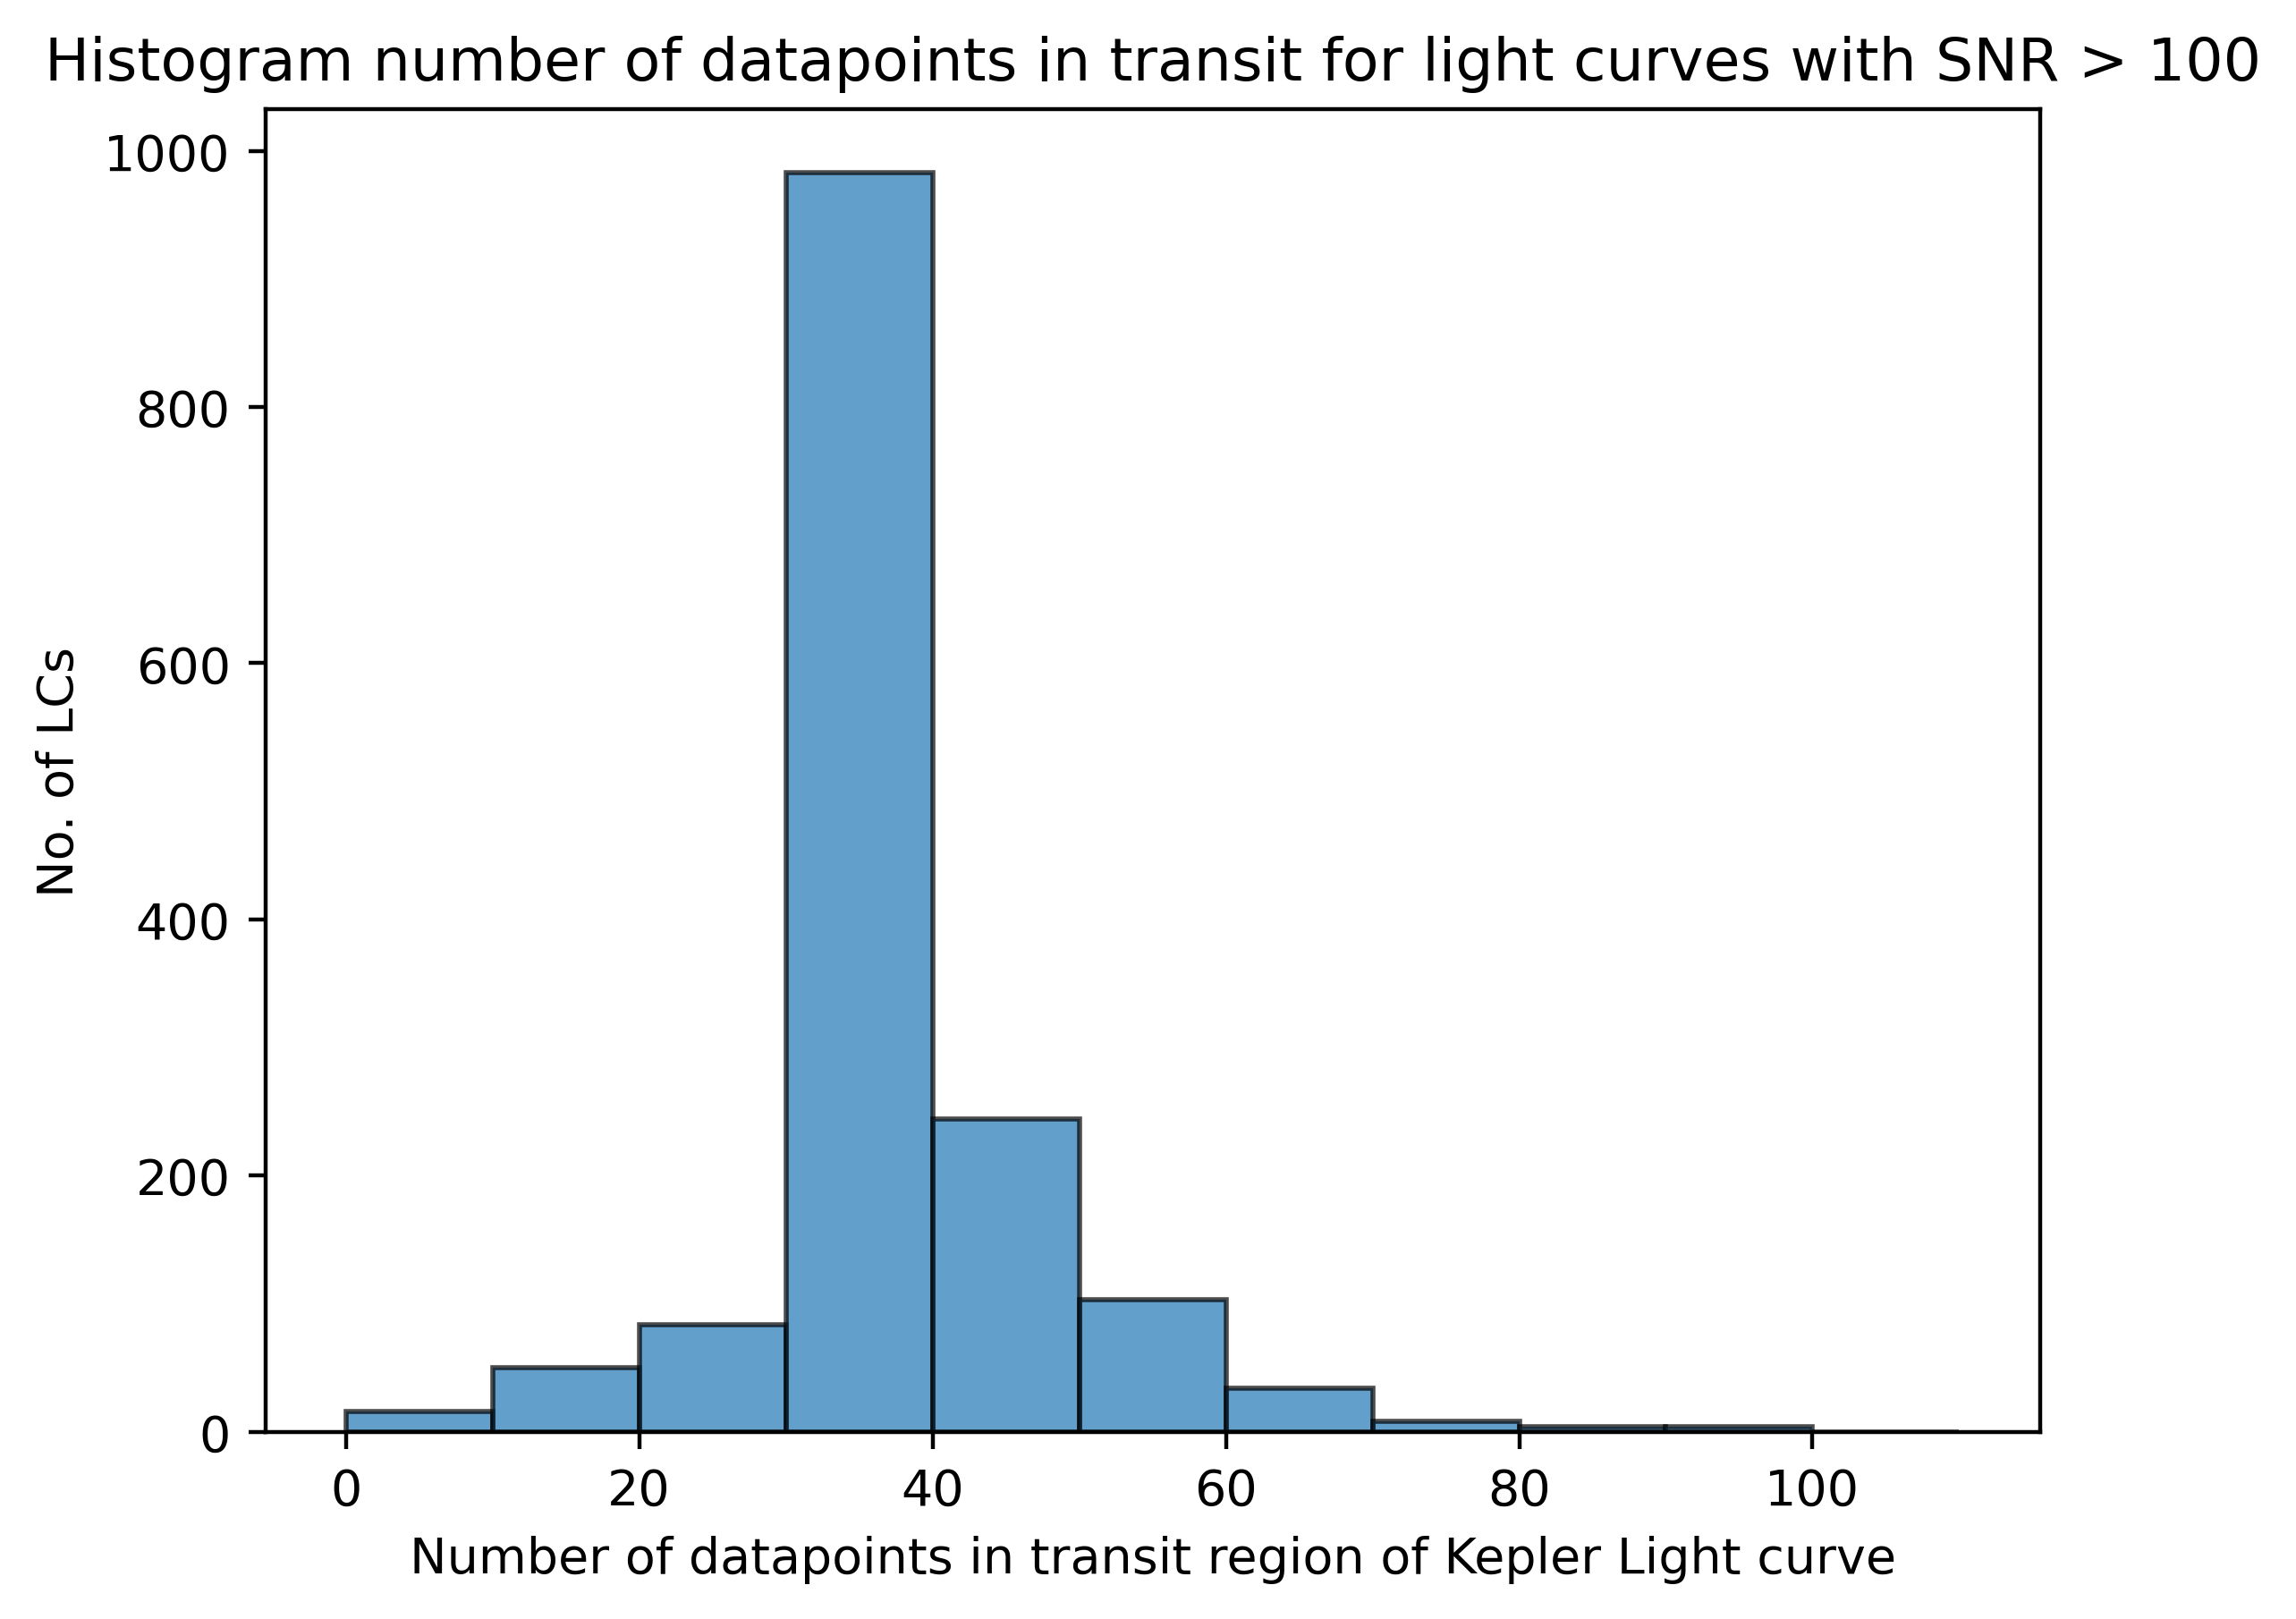

In [123]:
# Create a histogram for number of points in selected LC
# with percentages on the y-axis
# plt.hist(len_selected_portion[selected_kepler_index], bins=10, density=True, edgecolor='black', alpha=0.7)
# plt.ylabel('Percentage (%)')
bins = np.arange(0,120,10)
plt.hist(len_selected_portion[selected_kepler_index], bins=bins, edgecolor='black', alpha=0.7)
plt.ylabel('No. of LCs')

plt.xlabel('Number of datapoints in transit region of Kepler Light curve')
plt.title(f'Histogram number of datapoints in transit for light curves with SNR > {SNR_Threshold}')

# Show the plot
plt.show()

# Model Predictions

In [124]:
# # ML Prediciton
# model_load = load_model("../ml_model/sep22_singleModel_uniform_SNR/model_sep22_unf_50_500_v1.h5")
# local_view_predict_shape = model_load.predict(local_view_array_interpol)


In [125]:
# # plot the difference
# plt.rcParams['figure.dpi'] = 400
# fig,ax=plt.subplots(1,2, figsize=(11,2.5), gridspec_kw={ 'width_ratios': [2,1],
# 'wspace': 0.2,'hspace': 0.4})
# selected_kepler_index_elem = 286 #selected_kepler_index[0]
# print(kepid_array[selected_kepler_index_elem])

# ax[0].set_title(f'Interpolated KIC {kepid_array[selected_kepler_index_elem]} |{av_training_set_array[selected_kepler_index_elem]}',size=10)
# ax[0].plot(np.linspace(-1.0,1.0,len(local_view_array_interpol[0])),local_view_array_interpol[selected_kepler_index_elem])
# ax[0].grid('on')

# ax[1].set_title(f'Predicted Shape',size=10)
# img = ax[1].imshow(local_view_predict_shape[selected_kepler_index_elem],cmap='inferno')
# plt.colorbar(img)
# ax[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
# ax[1].grid('on')




In [126]:
# # plot the difference
# plt.rcParams['figure.dpi'] = 400
# fig,ax=plt.subplots(1,3, figsize=(15,2.5), gridspec_kw={ 'width_ratios': [2,2,2],
# 'wspace': 0.2,'hspace': 0.4})
# print(kepid_array[selected_kepler_index_elem])

# ax[0].set_title(f'(1) Interpolated KIC {kepid_array[selected_kepler_index_elem]}',size=10)
# ax[0].plot(np.linspace(-1.0,1.0,len(local_view_array_interpol[0])),local_view_array_interpol[selected_kepler_index_elem])
# ax[0].grid('on')

# ax[1].set_title(f'(2) Simulated LC (for circle)',size=10)
# ax[1].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],color="tab:red")
# ax[1].grid('on')


# ax[2].set_title(f'(2)-(1): Simulated LC - Kepler',size=10)
# ax[2].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0]-local_view_array_interpol[selected_kepler_index_elem],color="tab:green")
# ax[2].grid('on')

# # ax[1][0].set_title(f'(1) Interpolated KIC {kepid_array[selected_kepler_index_elem]}',size=10)
# # ax[1][0].plot(np.linspace(-1.0,1.0,len(local_view_array_interpol[0])),local_view_array_interpol[selected_kepler_index_elem])
# # ax[1][0].grid('on')

# # ax[1][1].set_title(f'(2) Simulated LC (for circle)',size=10)
# # ax[1][0].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0])
# # ax[1][1].grid('on')


# # ax[1][2].set_title(f'(2)-(1): Simulated LC - Kepler',size=10)
# # ax[1][2].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0]-local_view_array_interpol[selected_kepler_index_elem])
# # ax[1][2].grid('on')

# plt.show()

In [127]:
# num = 5
# fig,ax=plt.subplots(num,2, figsize=(7,5), gridspec_kw={ 'width_ratios': [2,1],
#         'wspace': 0.2,'hspace': 0.4})
# plt.rcParams['figure.dpi'] = 400

# ax[0][0].set_title('Input LC',size=10)
# ax[0][1].set_title('Predicted Shape',size=10)
# ax[num-1][0].set_xlabel('Phase',size=10)
# ph = np.linspace(-1.0,1.0,len(local_view_array_interpol[0]))
# # advance = 60
# for iteration in range(num):
#     selected_kepler_index_elem = selected_kepler_index[iteration]
#     ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
#     if(i<num-1): ax[iteration][0].tick_params(labelbottom = False, bottom = False)
#     img = ax[iteration][1].imshow(local_view_predict_shape[selected_kepler_index_elem],cmap='inferno')
#     plt.colorbar(img)
#     ax[iteration][0].set_ylabel('Flux',size=10)
#     # ax[i][0].set_ylim(-0.5,1.5)
#     ax[iteration][0].plot(ph, local_view_array_interpol[selected_kepler_index_elem],color = 'tab:red',linewidth=1.5)
#     ax[iteration][0].plot(ph, local_view_array_interpol[selected_kepler_index_elem],color = 'tab:red',linewidth=1.5)
#     ax[iteration][0].grid('on')
#     ax[iteration][0].plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:green")


#     left_index = int(center_index - int(count_zeros_array[selected_kepler_index_elem]/2)-int(count_zeros_array[selected_kepler_index_elem]/6)) 
#     right_index+1 = int(center_index + int(count_zeros_array[selected_kepler_index_elem]/2)+int(count_zeros_array[selected_kepler_index_elem]/6))
#     # print("left_index = ",left_index)
#     # print("right_index+1 = ",right_index+1)
#     lc_test=local_view_array[selected_kepler_index_elem][left_index:right_index+1]
#     ax[iteration][0].scatter(np.linspace(-1,1,len(lc_test)),lc_test,s=3,color='black')

# plt.suptitle('Test Dataset Prediction')
# plt.show()

In [128]:
#     selected_portion = lc_np_array_offset[iteration][int(min_index_lc_np_array_offset-(count_zeros/2)-(horiz_select)):int(min_index_lc_np_array_offset+(count_zeros/2)+(horiz_select))]
#     selected_portion_mask = lc_np_array_offset_mask[iteration][int(min_index_lc_np_array_offset-(count_zeros/2)-(horiz_select)):int(min_index_lc_np_array_offset+(count_zeros/2)+(horiz_select))]
    
#     print('len_of_selected_portion = ',len(selected_portion))

#     # plt.plot(np.linspace(0,1,len(selected_portion)),selected_portion)
#     # plt.plot(np.linspace(0,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0])
#     # plt.plot(np.linspace(0,1,len(selected_portion_mask)),selected_portion_mask)
#     # plt.plot(np.linspace(0,1,len(lc_np_array_offset[selected_kepler_index[iter]])),lc_np_array_offset[selected_kepler_index[iter]])
#     # plt.plot(np.linspace(0,1,len(lc_np_array_offset_mask[selected_kepler_index[iter]])),lc_np_array_offset_mask[selected_kepler_index[iter]])

#     # Interpolate the selected portion
#     # Original data with 30 elements
#     original_x = np.linspace(0, 100, num=len(selected_portion))
#     original_y = selected_portion  # Replace with your actual data

#     # Create a quadratic interpolation function
#     f = interp1d(original_x, original_y, kind='quadratic')

#     # Define the range of x-values for the interpolation with 120 elements
#     x_interpolation = np.linspace(0, 100, num=len(train_lc_scaled_append[0]))

#     # Perform the interpolation
#     y_interpolated = f(x_interpolation)
#     lc_np_array_interpol[iteration] = y_interpolated
    
# plt.plot(np.linspace(0,1,len(lc_np_array_interpol[selected_kepler_index[0]])),lc_np_array_interpol[selected_kepler_index[0]],color='black')
# plt.grid('on')
# plt.show()

In [129]:
# # # Single Planet LC for visualization
# # plt.rcParams['figure.dpi'] = 400
# # plt.title(f"KIC: {kepid_array[selected_kepler_index[0]]} | {selected_kepler_index[0]} | {av_training_set_array[selected_kepler_index[0]]}")
# # plt.scatter(ph_kepler,local_view_array[selected_kepler_index[0]],s=5)
# # plt.grid('on')
# # plt.show()

# # Single Simulate LC for visualization
# # plt.rcParams['figure.dpi'] = 400
# # plt.title(f"Simulated LC")
# # plt.plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:green")
# # plt.grid('on')
# # plt.show()

# # Overlap simulate LC and Kepler
# plt.rcParams['figure.dpi'] = 400
# plt.title(f"Simulated LC")
# plt.plot(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:green")
# plt.grid('on')
# plt.show()
